# **Anticipation des besoins en consommation électrique de bâtiments**
*Sofia Chevrolat (Juillet 2020)*
___
Cette étude en deux notebooks vise à estimer les émissions de CO2 et la consommation totale d’énergie de bâtiments de la ville de Seattle en exploitant leurs données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..) mises à disposition par la ville pour les années 2015 et 2016.

___
_**Remerciements**:<br>
Merci à mon compagnon [J. Duplan](https://www.linkedin.com/in/julian-duplan-64844a41/) pour les discussions intéressantes.<br>
Merci également à mon mentor [Samia Drappeau](https://www.linkedin.com/in/samiadrappeau) pour les échanges d'idées, les conseils et les encouragements!_
___

Cette étude est organisée en 2 notebooks: 
- Notebook de nettoyage, feature engineering et analyse exploratoire
- Notebook de modélisations et prédictions

___
## Notebook 1 : Nettoyage, Feature Engineering et Analyse Exploratoire

Ce notebook est organisé comme suit:

**0. Mise en place**
- 0.1 Chargement des librairies et fonctions utiles
- 0.2 Chargement et description du jeu de données
- 0.3 Assemblage des jeux de données
    * 0.3.1 Suppression des colonnes non présentes d'une année à l'autre
    * 0.3.2 Harmonisation des features
    * 0.3.3 Fusion des jeux de données
    
**1. Ciblage des données : Restriction aux bâtiments non destinés à l'habitation**

**2. Nettoyage du jeu de données**
- 2.1 Suppression des features non exploitables
- 2.2 Suppression des features redondantes
- 2.3 Suppression des outliers
- 2.4 Suppression des features les moins renseignées
- 2.5 Suppression des observations intégralement vides
- 2.6 Suppression des valeurs NaN
- 2.7 Nettoyage des valeurs string
- 2.8 Correction des types
- 2.9 Suppression des valeurs aberrantes
- 2.10 Réindexation

**3. Feature Engineering**
- 3.1 Encodage et feature engineering
- 3.2 Création de nouvelles features

**4. Analyse exploratoire**
- 4.0 Séparation du jeu de données
- 4.1 Étude de la répartition des différentes sources d'énergie
    * 4.1.1 Tous bâtiments confondus
    * 4.1.2 Par type principal de bâtiment
- 4.2 Grandeurs statistiques
    * 4.2.1 Tendance centrale
        * 4.2.1.1 Features qualitatives
        * 4.2.1.2 Features quantitatives
    * 4.2.2 Distribution des features
        * 4.2.1.1 Features qualitatives
        * 4.2.1.2 Features quantitatives
- 4.3 Étude de la 1ère variable d'intérêt : la consommation énergétique (<i>SiteEnergyUse(kBtu)</i>)
    * 4.3.1 Étude des corrélations des variables qualitatives avec la consommation énergétique totale
    * 4.3.2 Étude des corrélations des variables quantitatives avec la consommation énergétique totale
- 4.4 Étude de la 2nde variable d'intérêt : les émissions de CO2 (<i>TotalGHGEmissions</i>)
    * 4.4.1 Étude des corrélations des variables qualitatives avec les émissions totales de CO2
    * 4.4.2 Étude des corrélations des variables quantitatives avec les émissions totales de CO2

**5. Export des données**

**6. Conclusion**

**7. Annexes**

___
### 0. MISE EN PLACE

Dans cette première étape, le cadre de travail est mis en place, c'est-à-dire :
- Les librairies et packages Python nécessaires sont chargés
- Les fonctions utiles sont définies
- Le jeu de données est chargé
___

___
#### 0.1 CHARGEMENT DES LIBRAIRIES ET FONCTIONS UTILES

In [1]:
import math
import pandas as pd
import numpy as np
import re

In [2]:
import helper_functions as hf

**_N.B : Le code des fonctions implémentées dans helper_functions dans le cadre de cette étude est également disponible en fin de notebook, section "Annexes"_**
___
#### 0.2 CHARGEMENT ET DESCRIPTION DU JEU DE DONNÉES

In [3]:
energy_data_2015 = pd.read_csv("./sources/2015-building-energy-benchmarking.csv", sep=",")
energy_data_2016 = pd.read_csv("./sources/2016-building-energy-benchmarking.csv", sep=",")

In [4]:
hf.descriptionJeuDeDonnees({'Energy Data 2015':[energy_data_2015, "Relevés 2015"], 
                            'Energy Data 2016': [energy_data_2016, "Relevés 2016"]})

Les données se décomposent en 2 fichier(s): 



Nom du fichier  Nb de lignes  Nb de colonnes   Description
1  Energy Data 2015          3340              47  Relevés 2015
2  Energy Data 2016          3376              46  Relevés 2016

___
#### 0.3 ASSEMBLAGE DES JEUX DE DONNÉES

On va assembler les 2 jeux de données afin de les nettoyer simultanément.
De plus, ces jeux de données devront être utilisés de façon similaire. Il faut donc les harmoniser en termes de features.

___
##### _<u>0.3.1 Suppression des colonnes non présentes d'une année à l'autre</u>_

Colonnes du jeu de données 2015 non présentes dans le jeu de données 2016:

In [5]:
[col for col in energy_data_2015.columns if col not in energy_data_2016.columns]

['Location',
 'OtherFuelUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Comment',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'SPD Beats',
 'Zip Codes']

Colonnes du jeu de données 2016 non présentes dans le jeu de données 2015:

In [6]:
[col for col in energy_data_2016.columns if col not in energy_data_2015.columns]

['Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'Comments',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

- La colonne "Location" a été décomposée en ses différentes composantes dans le data set 2016, à savoir :
    - Latitude
    - Longitude
    - Address
    - City
    - State
    - ZipCode
    
Elle est donc à conserver. Il faudra la décomposer en ses éléments par la suite pour harmoniser.

- La colonne "Zip Codes" du set de 2015 correspond à la colonne "ZipCode" du set de 2016.

Il en va de même pour les colonnes:
    - "GHGEmissions(MetricTonsCO2e)" (2015) et "TotalGHGEmissions" (2016), 
    - "GHGEmissionsIntensity(kgCO2e/ft2)" (2015) et "GHGEmissionsIntensity" (2016).
    - "Comment" (2015) et "Comments" (2015)
Celles-ci sont donc à conserver, et harmonisant leur nom sur les deux jeux de données.

In [7]:
energy_data_2015.drop(columns=["OtherFuelUse(kBtu)", "2010 Census Tracts", 
                               "Seattle Police Department Micro Community Policing Plan Areas",
                               "City Council Districts","SPD Beats"], 
                      inplace=True)

___
##### _<u>0.3.2 Harmonisation des features</u>_

###### Harmonisation des noms

On renomme les colonnes pertinentes telles qu'elles sont nommées dans le jeu de données 2016.

In [8]:
energy_data_2015.rename(columns={"GHGEmissions(MetricTonsCO2e)":"TotalGHGEmissions",
                                 "GHGEmissionsIntensity(kgCO2e/ft2)":"GHGEmissionsIntensity", 
                                 "Zip Codes":"ZipCode", 
                                 "Comment":"Comments"}, inplace=True)

###### Décomposition de la colonne "Location" (jeu de données 2015) et de la colonne "Address" (jeu de données 2016)

In [9]:
# Split de la colonne Location avec le séparateur ","

location_df = energy_data_2015['Location'].apply(lambda x: pd.Series(x.split(',')))


# Renommage des colonnes ainsi obtenues

location_df.rename(columns={0:"Latitude", 
                            1:"Longitude", 
                            2:"Address", 
                            3:"City", 4:"State", 5:"Zip"}, 
                   inplace=True)


# Suppression des colonnes non utilisées : 
# - City est toujours égale à "Seattle"
# - State est toujours égal à "Washington"
# - Zip sera récupéré dans la colonne "Zip Codes"

location_df.drop(columns=["City", "State", "Zip"], inplace=True)
energy_data_2016.drop(columns=["City", "State"], inplace=True)


# Split de la colonne Latitude pour obtenir uniquement la donnée chiffrée

location_df["Latitude"] = location_df["Latitude"]\
                                    .apply(lambda x: pd.Series(x.split(':')))\
                                    .loc[:,1].str.strip("' ").astype('float')


# Split de la colonne Longitude pour obtenir uniquement la donnée chiffrée

location_df["Longitude"] = location_df["Longitude"]\
                                    .apply(lambda x: pd.Series(x.split(':')))\
                                    .loc[:,1].str.strip("' ").astype('float')


# Split de la colonne StreetAddress pour obtenir uniquement la donnée

location_df["Address"] = location_df["Address"]\
                                        .apply(lambda x: pd.Series(x.split(':')))\
                                        .loc[:,2].str.strip(' "')

# Split de la colonne StreetAddress pour obtenir uniquement les données numéro et nom de rue

location_df["StreetNumber"] = location_df["Address"]\
                                        .apply(lambda x: pd.Series(x.split(" ", 1))).loc[:,0]

energy_data_2016["StreetNumber"] = energy_data_2016["Address"]\
                                        .apply(lambda x: pd.Series(x.split(" ", 1))).loc[:,0]


location_df["StreetName"] = location_df["Address"]\
                                        .apply(lambda x: pd.Series(x.split(" ", 1))).loc[:,1]

energy_data_2016["StreetName"] = energy_data_2016["Address"]\
                                        .apply(lambda x: pd.Series(x.split(" ", 1))).loc[:,1]

# Ajout des nouvelles colonnes à la dataframe et suppression :
# - de l'ancienne colonne Location
# - de la colonne de travail Location_StreetAddress

energy_data_2015 = pd.concat([energy_data_2015, location_df], axis=1).drop(columns=["Location", "Address"])
energy_data_2016 = energy_data_2016.drop(columns=["Address"])

___
##### _<u>0.3.3 Fusion des jeux de données pour nettoyage et feature engineering</u>_

In [10]:
total_data = pd.concat([energy_data_2015, energy_data_2016]).reset_index(drop=True)

___
### 1. CIBLAGE DES DONNÉES : Restriction aux bâtiments non destinés à l'habitation

Comme indiqué dans l'introduction, l'équipe s'intéresse de près aux émissions des bâtiments non destinés à l'habitation.<br>
Les données pertinentes sont donc uniquement celles concernant ces types de bâtiments, c'est donc à celles-ci que nous allons nous restreindre.

In [11]:
total_data = total_data[~total_data["BuildingType"]\
                        .isin([hab for hab in total_data["BuildingType"]\
                        .unique() if hab.startswith('Multifamily')])]

___
### 2. NETTOYAGE DU JEU DE DONNÉES

___
#### 2.1 SUPPRESSION DES FEATURES NON EXPLOITABLES POUR UNE ANALYSE

In [12]:
total_data.drop(columns=["Comments", "ComplianceStatus",
                         "PropertyName", "TaxParcelIdentificationNumber"], inplace=True)

Bien que non exploitable pour l'analyse, on va conserver "OSEBuildingID" afin de pouvoir éventuellement relier un bâtiment du jeu de données 2015 au même bâtiment du jeu de données 2016 au besoin.

___
#### 2.2 SUPPRESSION DES FEATURES REDONDANTES

Il n'y a pas de doublons d'observations (dans chaque jeu de données séparé). 

Toutefois, certaines features :
- contiennent les mêmes valeurs que d'autres colonnes (<i>"Electricity(kBtu)"</i> et <i>"Electricity(kWh)"</i>, <i>"NaturalGas(therms)"</i> et <i>"NaturalGas(kBtu)"</i>), avec une unité différente.
- sont calculées à partir d'opérations arithmétiques simples sur d'autres colonnes (<i>"SiteEUI(kBtu/sf)"</i> et <i>"SiteEnergyUse(kBtu)"</i>)

In [13]:
# Removing columns that are doublons of other columns

total_data = total_data.drop(columns=['Electricity(kWh)', 'NaturalGas(therms)',
                                      'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 
                                      'SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)', 
                                      'PropertyGFATotal',
                                      'SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity'])

___
#### 2.3 SUPPRESSION DES OUTLIERS

Le jeu de données comporte une colonne "Outlier" indiquant le caractère "outlier" ("low" ou "high") d'un bâtiment en termes de EUI (Energy Use Intensity)[1](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/understand-metrics/what-energy).
Dans ce contexte, un bâtiment indiqué "outlier" est un bâtiment dont l'EUI se situe dans les 5% les plus extrêmes (hauts ou bas)[2](http://www.seattle.gov/Documents/Departments/OSE/EBR-2013-report.pdf).

Bien qu'il soit possible de les expliquer dans certains cas, nous allons les écarter de l'analyse, car ils représentent des cas limites d'un point de vue métier.

In [14]:
total_data = total_data[total_data["Outlier"].isna()]

___
#### 2.4 SUPPRESSION DES FEATURES LES MOINS RENSEIGNÉES

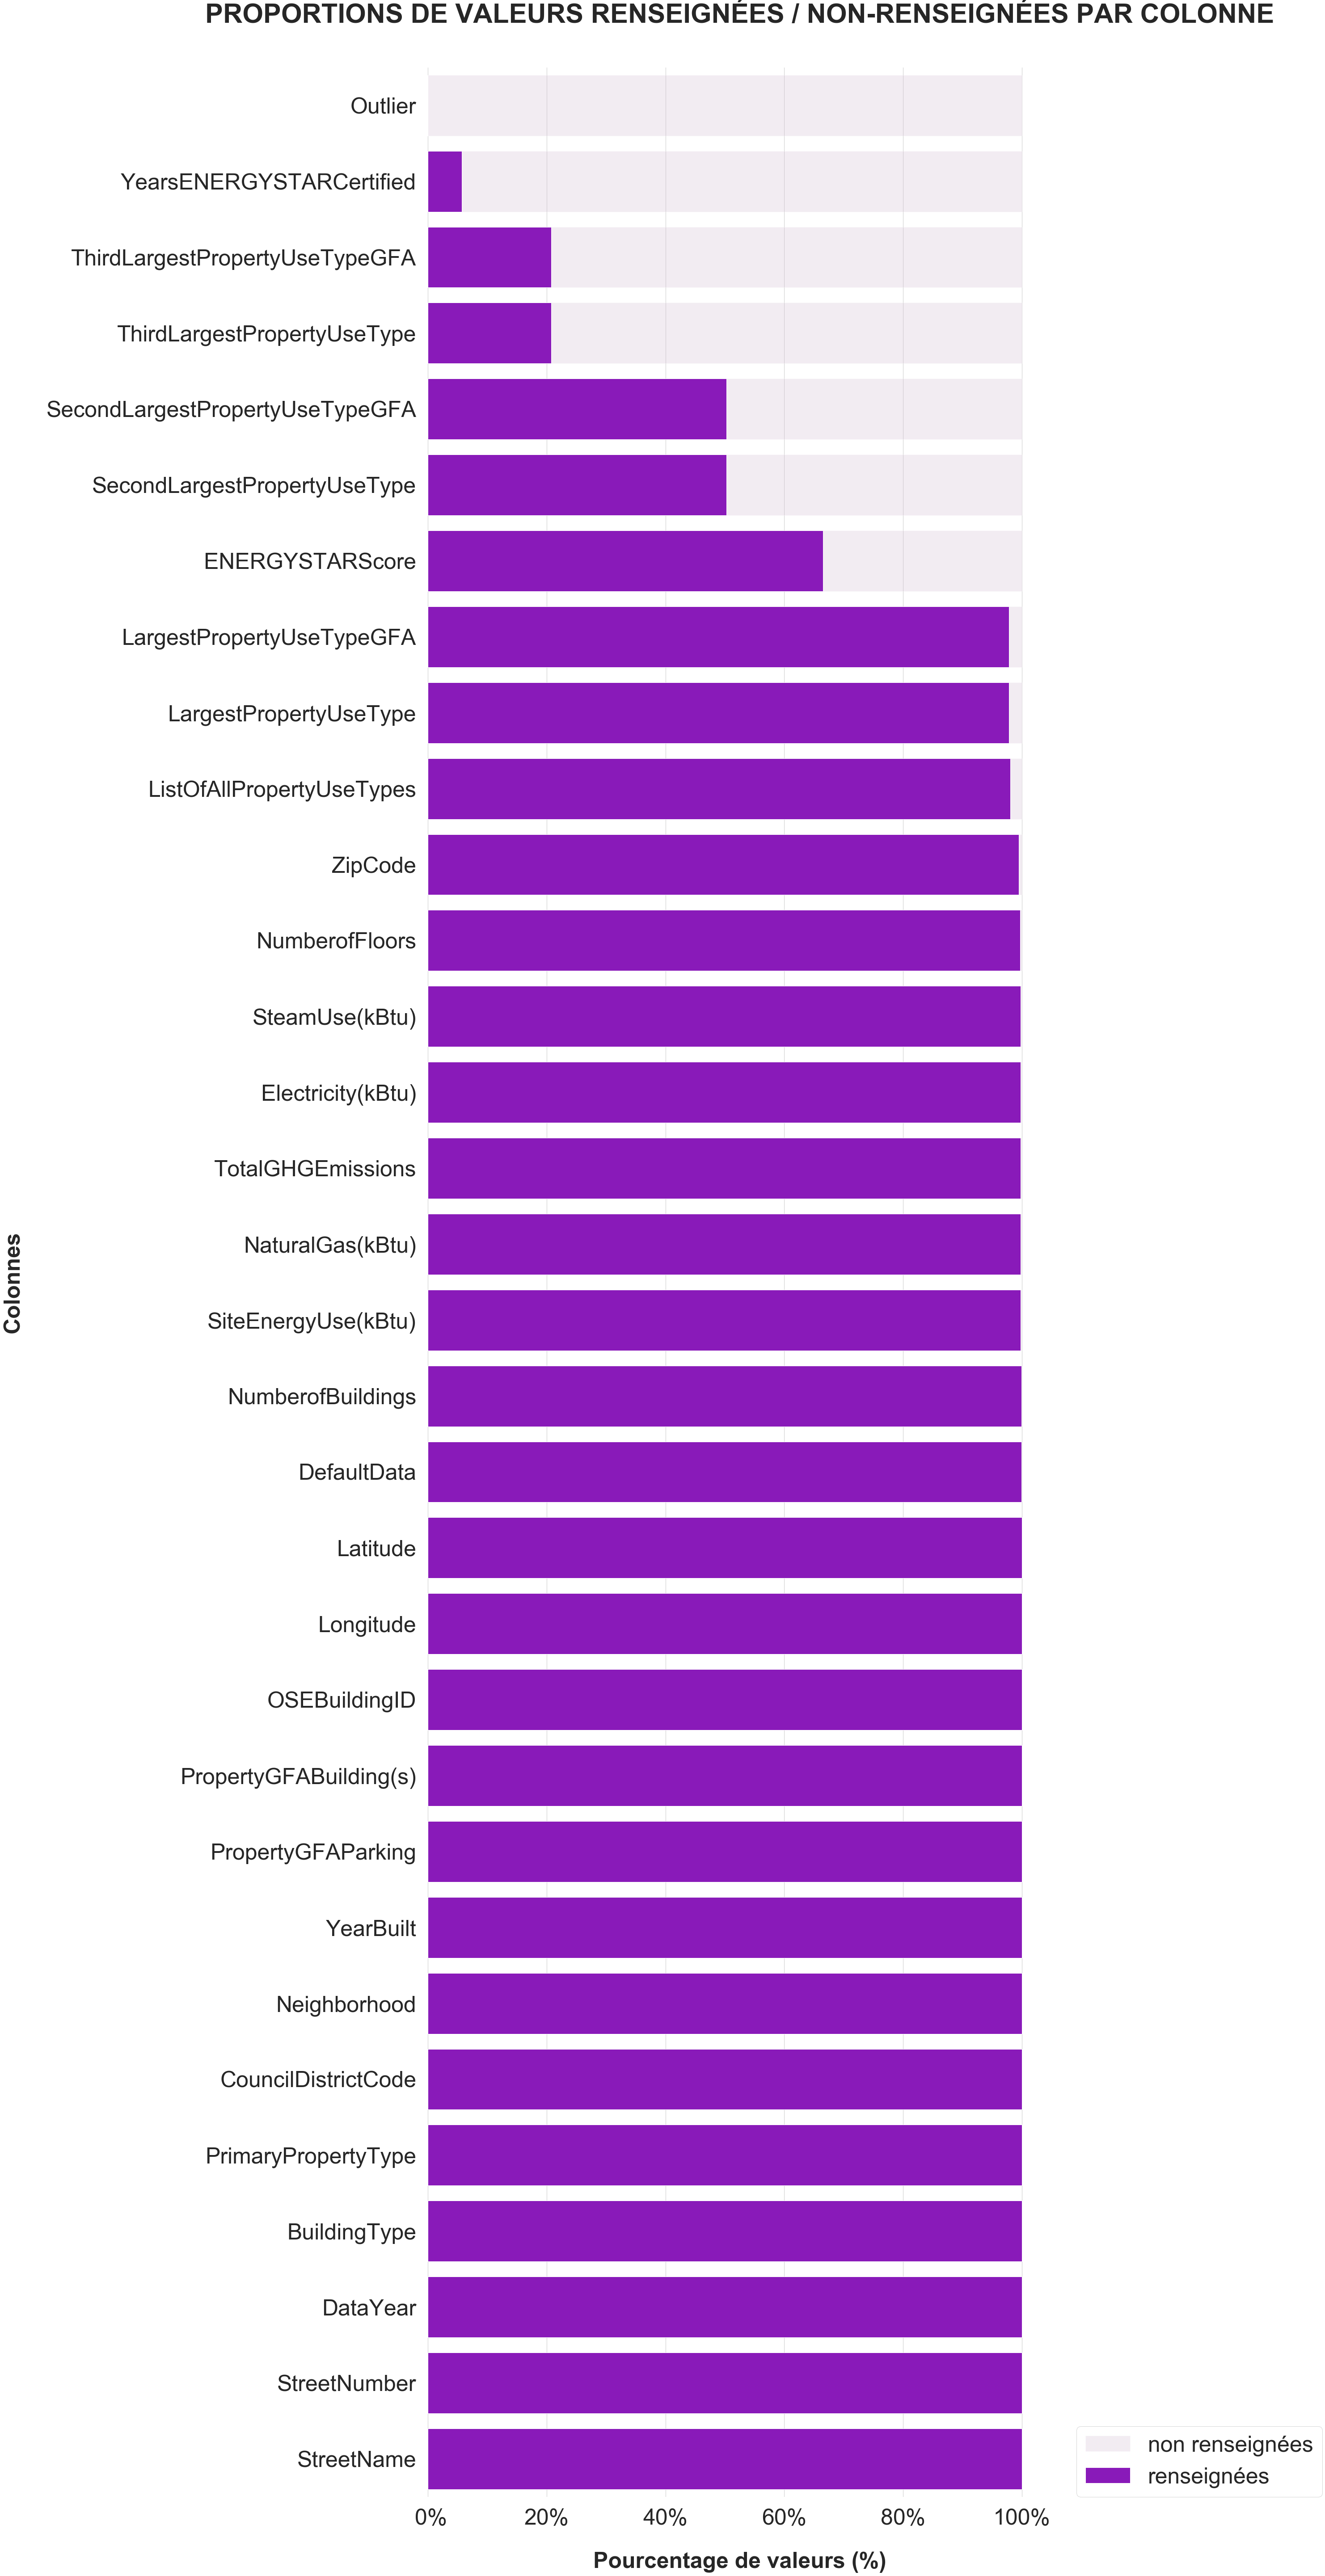

In [15]:
# Visualising filling rates for each column
hf.plotPercentageMissingValuesFor(total_data, 25, 100)

L'écransante majorité des features sont très bien renseignées (taux de remplissage > 90%).

Afin d'avoir un jeu de données aussi qualitatif que possible, les colonnes considérées vont être restreintes 
à celles dont le taux de données non renseignées est inférieur à 5%.

In [16]:
missing_percent_df = hf.getMissingValuesPercentPer(total_data)\
                       .rename(columns={"Percent Missing":"PercentMissing"})

In [17]:
columns_selected = [col for col in total_data.columns if missing_percent_df.loc[col,"PercentMissing"]<5]

In [18]:
total_data = total_data[list(columns_selected)]

___
#### 2.5 SUPPRESSION DES OBSERVATIONS INTÉGRALEMENT VIDES

In [19]:
# Dropping all rows that are entirely empty. There are no empty columns.

total_data = total_data.dropna(how='all', axis=1)

___
#### 2.6 SUPPRESSION DES VALEURS NAN

Leur nombre étant très faible sur les features conservées, on supprime les lignes présentant des valeurs NaN.

In [20]:
total_data = total_data.dropna()

___
#### 2.7 NETTOYAGE DES VALEURS  STRING

In [21]:
# Harmonisation des dénominations des types de propriété principaux
# en retirant retours chariots inutiles

total_data = total_data.replace('\n','', regex=True)

In [22]:
# Harmonisation des graphies en mettant tout en majuscule

for col in total_data.loc[:, total_data.dtypes == object].columns:
    total_data[col] = total_data[col].str.upper()

___
#### 2.8 CORRECTION DES TYPES

On conserve uniquement les lignes où le numéro de rue est bien un nombre.

In [23]:
# Keep street numbers that contain only digits

total_data = total_data[total_data["StreetNumber"].str.match(r'^([\s\d]+)$')]

In [24]:
# Change column type to float

total_data.loc[:,"StreetNumber"] = total_data.loc[:, "StreetNumber"].astype('float')

___
#### 2.9 SUPPRESSION DES VALEURS ABERRANTES

- Certains bâtiments sont indiqués comme ayant une consommation énergétique nulle / négative, et / ou des émissions carbone nulles.

Il s'agit soit de bâtiments désaffectés, soit d'erreurs. Nous allons donc les supprimer du jeu de données.

In [25]:
# Keeping only buildings with total energy use > 0

total_data = total_data[total_data["SiteEnergyUse(kBtu)"]>0]

In [26]:
# Keeping only buildings with carbon emissions > 0

total_data = total_data[total_data["TotalGHGEmissions"]>0]

- La plus haute tour de Seattle a 93 étages. 

Tout bâtiment dont le nombre indiqué est supérieur à 93 comporte donc une valeur erronée. Nous allons donc les supprimer du jeu de données.

In [27]:
# Buildings with more than 93 floors are incorrect

row = total_data[total_data["NumberofFloors"]>93]

total_data.loc[row.index, "NumberofFloors"] = 1

___
#### 2.10 RÉINDEXATION

In [28]:
total_data = total_data.reset_index(drop=True)

___
### 3. FEATURE ENGINEERING

___
#### 3.1 ENCODAGE ET FEATURE HASHING

**Colonne ListOfAllPropertyUseTypes**

Cette colonne contient, pour chaque bâtiment, les différents usages qui en sont faits.
Nous allons créer une colonne par valeur unique possible, et attribuer, pour chaque colonne et chaque bâtiment:
- 1 si le bâtiment a l'usage en question
- 0 sinon

In [29]:
total_data["ListOfAllPropertyUseTypes"] = total_data["ListOfAllPropertyUseTypes"]\
                                          .apply(lambda x: re.sub(r'\([^)]*\)', '', x)).str.replace(" ", "")

In [30]:
# Valeurs uniques existantes
flat_list = set([item for sublist in total_data["ListOfAllPropertyUseTypes"].to_list() \
                 for item in sublist.strip().split(',')])

In [31]:
for pu in flat_list:
    new_column_name = "LoAPUT_"+pu
     
    total_data[new_column_name]=0

In [32]:
for pu in flat_list:
    column_name = "LoAPUT_"+pu
    
    total_data.loc[total_data['ListOfAllPropertyUseTypes'].str.contains(pu), column_name] = 1

In [33]:
total_data.drop(columns=["ListOfAllPropertyUseTypes"], inplace=True)

**Colonne DefaultData**

Cette colonne prend uniquement 2 valeurs. On peut donc la convertir directement en une variable binaire, où :
- "No" -> 0
- "Yes" -> 1

In [34]:
total_data.loc[total_data["DefaultData"]=="NO", "DefaultData"] = 0
total_data.loc[total_data["DefaultData"]=="YES", "DefaultData"] = 1

**One Hot Encoding pour les variables prenant peu de valeurs potentielles:**
- BuildingType
- Neighborhood
- CouncilDistrictCode

In [35]:
cols_to_dummies = ['BuildingType','Neighborhood', 'CouncilDistrictCode']

total_data = pd.concat([total_data[["BuildingType", "Neighborhood"]], 
                        pd.get_dummies(total_data, columns=cols_to_dummies)], axis=1)

**Feature Hashing pour les variables prenant un grand nombre de valeurs potentielles:**
    - PrimaryPropertyType
    - LargestPropertyUseType
    - StreetName

In [36]:
cols_prefix = {"PrimaryPropertyType":"PPT",
               "LargestPropertyUseType":"LPUT", 
               "StreetName":"SN"}

In [37]:
from sklearn.feature_extraction import FeatureHasher

fh = FeatureHasher(n_features=6, input_type='string')

In [38]:
for col, pref_col in cols_prefix.items():
    hashed_features = fh.fit_transform(total_data[col].astype("str"))
    hashed_features = hashed_features.toarray()
    hashed_df = pd.DataFrame(hashed_features).rename(columns={0:pref_col+"_0", 1:pref_col+"_1", 
                                                              2:pref_col+"_2", 3:pref_col+"_3", 
                                                              4:pref_col+"_4", 5:pref_col+"_5"})

    total_data = pd.concat([total_data, hashed_df], axis=1)

___
#### 3.2 CRÉATION DE NOUVELLES FEATURES

Nous souhaitons prédire la consommation énergétique d'un bâtiment. 
Les informations indiquant la consommation énergétique annuelle par type de source d'énergie ne pourront donc être utilisées telles quelles, car il s'agirait d'une fuite de données.

Nous pouvons toutefois les exploiter en remplaçant les valeurs qu'elles expriment par la proportion qu'elles représentent sur l'ensemble des sources d'énergie.

In [39]:
# Création des nouvelles features

for nrj_source in ["SteamUse", "Electricity", "NaturalGas"]:
    total_data[nrj_source+"(%)"]=total_data[nrj_source+"(kBtu)"]/total_data["SiteEnergyUse(kBtu)"]*100

In [40]:
# Suppression des features qui ne peuvent pas être utilisées

total_data.drop(columns=["Electricity(kBtu)", "NaturalGas(kBtu)", "SteamUse(kBtu)"], inplace=True)

___
### 4. ANALYSE EXPLORATOIRE

Le jeu de données 2015 doit servir à l'entraînement du modèle, tandis que le jeu de données 2016 va servir de jeu de validation.

On les sépare donc à nouveau avant de débuter l'analyse.

___
#### 4.0 SÉPARATION DU JEU DE DONNÉES

In [41]:
train_test_data = total_data[total_data["DataYear"].isin(["2015"])]
validation_data = total_data[total_data["DataYear"].isin(["2016"])]

____
#### 4.1 ÉTUDE DE LA PROPORTION DES DIFFÉRENTES SOURCES D'ÉNERGIE

La consommation totale d'énergie, ainsi que les émissions d'énergie, sont a priori très liées aux différents types d'énergie.

Nous allons donc nous intésser à celles-ci en premier lieu.

#### _<u>4.1.1 Tous bâtiments confondus</u>_

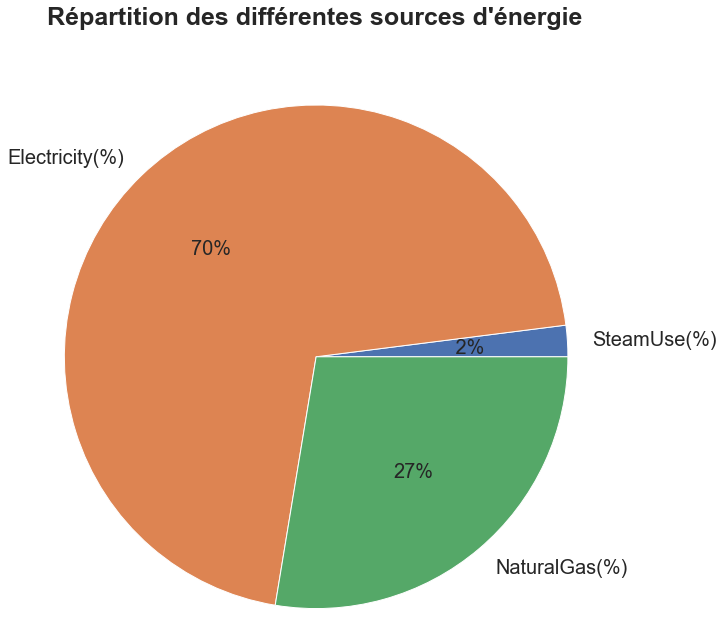

In [42]:
hf.plotPieChart(train_test_data[['SteamUse(%)', 'Electricity(%)', 'NaturalGas(%)']].mean(), 
                          10, 10, 
                          "Répartition des différentes sources d'énergie")

L'électricité est la source d'énergie la plus largement utilisée.

#### _<u>4.1.2 Par type principal de bâtiment</u>_

In [43]:
# Transformation des données pour l'histogramme
data_SEU_stacked = train_test_data.copy()[["PrimaryPropertyType",
                                           "Electricity(%)", "NaturalGas(%)", "SteamUse(%)"]]\
                    .groupby(["PrimaryPropertyType"])\
                    .agg("mean")\
                    .cumsum(axis=1)\
                    .applymap(lambda x: math.trunc(x))

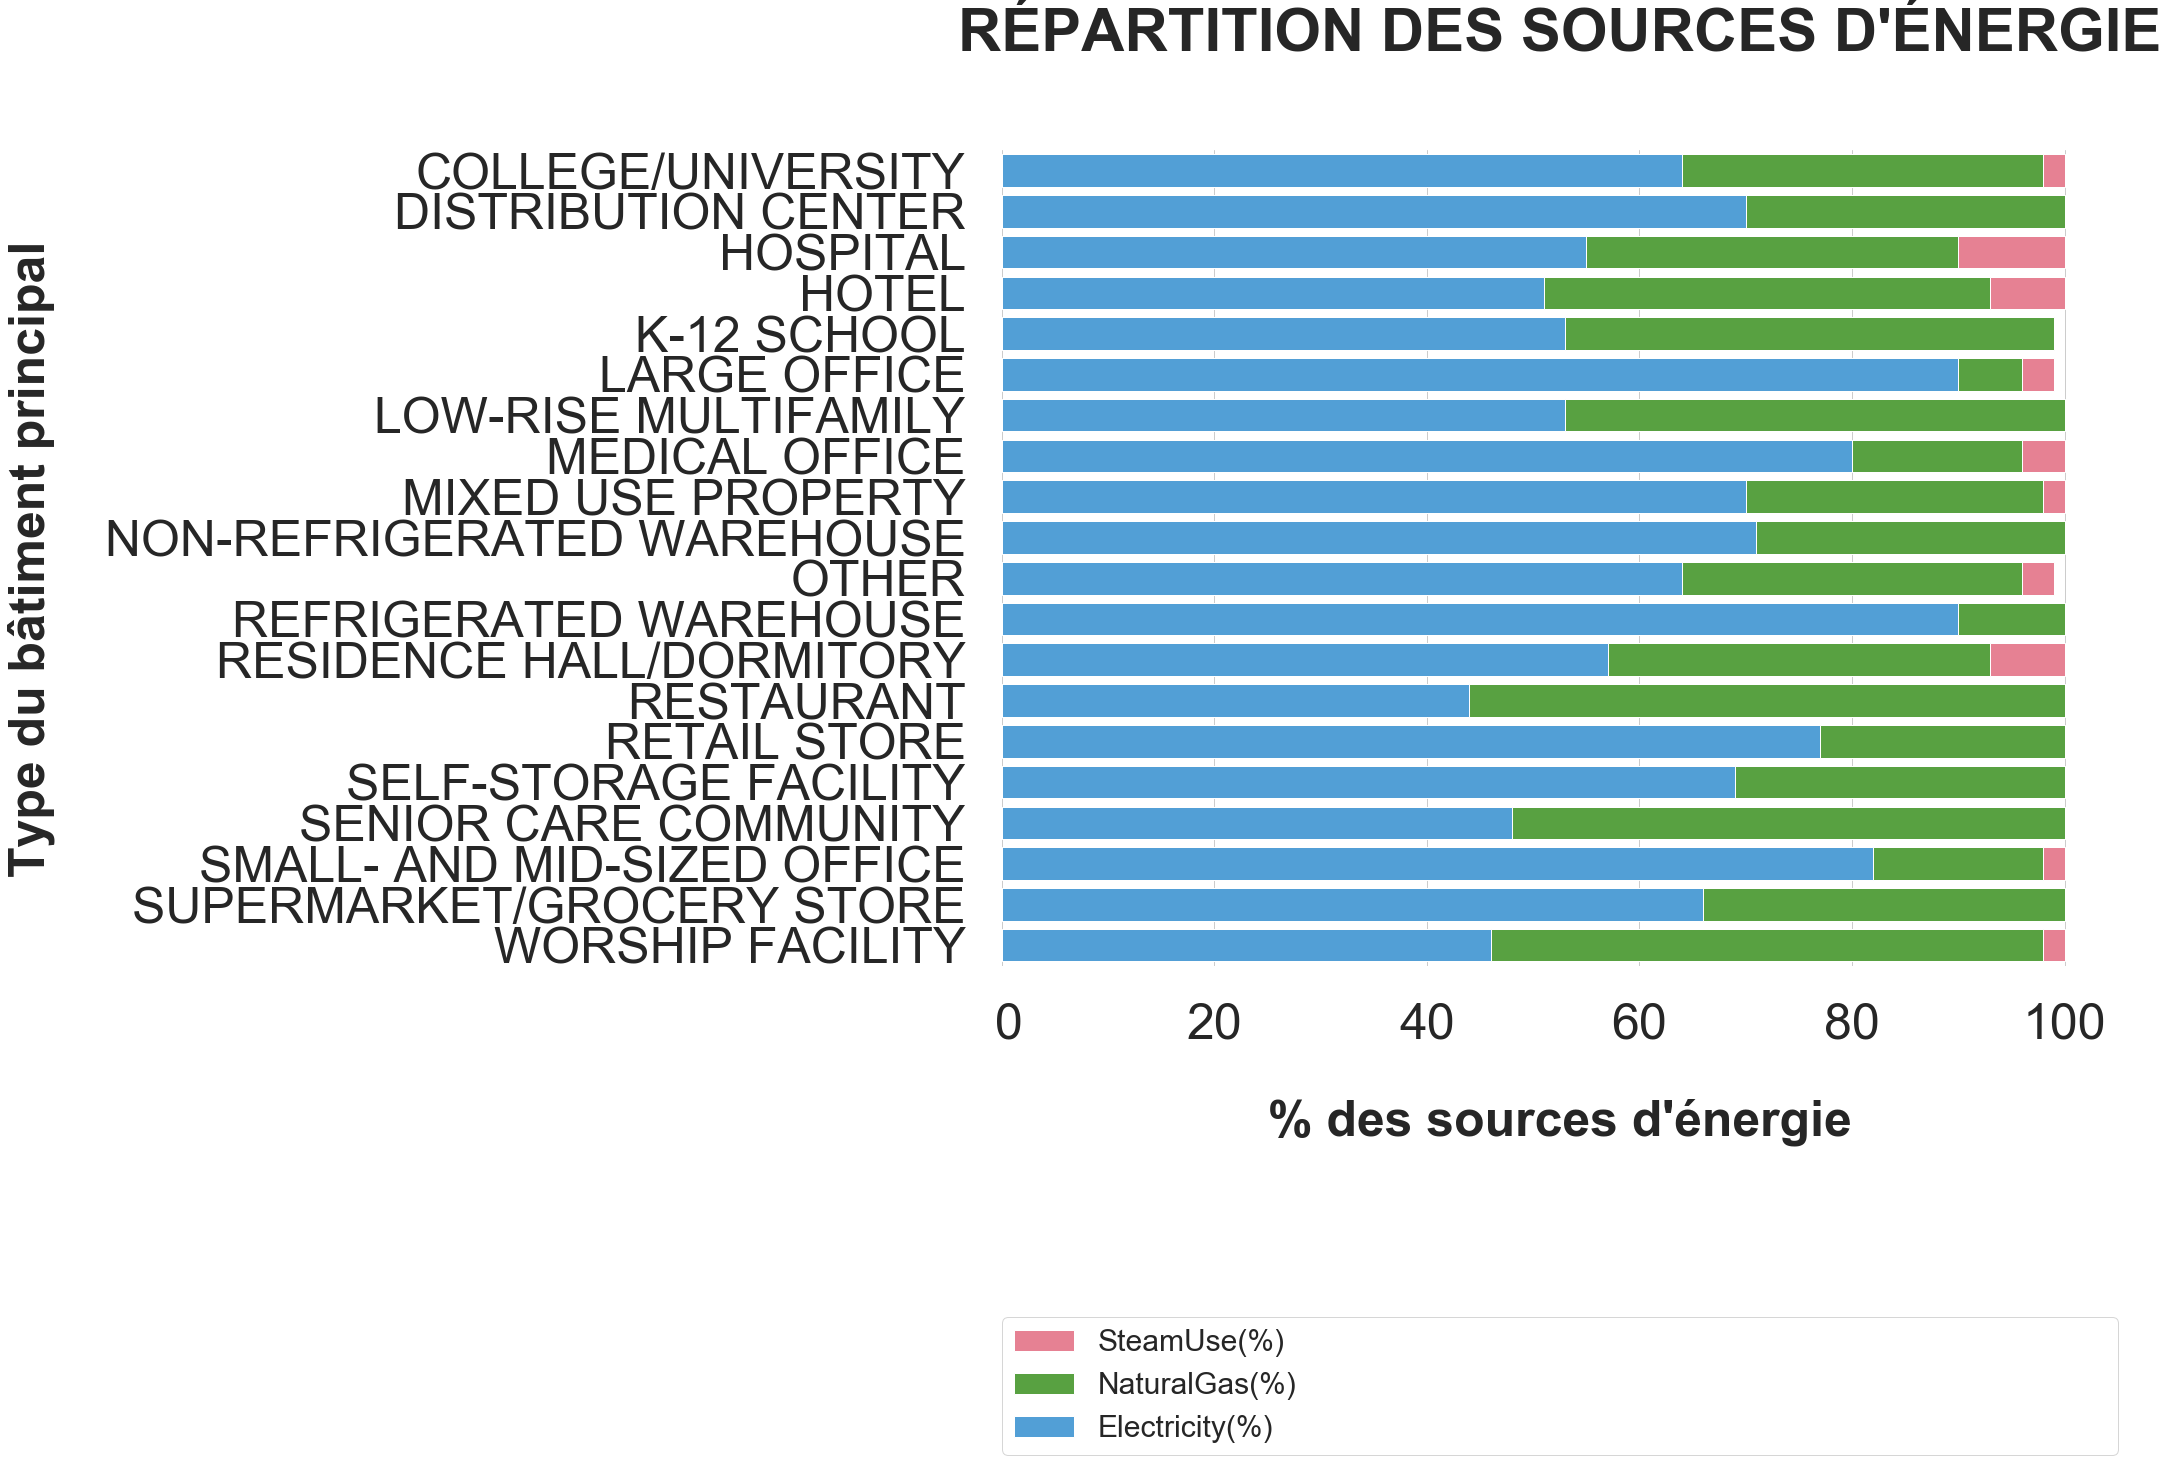

In [44]:
hf.plotEnergySourcesDistributionFor(data_SEU_stacked, "PrimaryPropertyType", 20, 15)

___
#### 4.2 GRANDEURS STATISTIQUES

In [45]:
qualitative_cols = ['BuildingType',
                    'PrimaryPropertyType',
                    'LargestPropertyUseType', 
                    'Neighborhood',
                    'ZipCode',
                    'YearBuilt']

In [46]:
quantitative_cols = ['PropertyGFAParking','PropertyGFABuilding(s)',
                     'LargestPropertyUseTypeGFA',
                     'NumberofBuildings','NumberofFloors',
                     'SiteEnergyUse(kBtu)','SteamUse(%)', 'Electricity(%)', 'NaturalGas(%)',
                     'TotalGHGEmissions','DefaultData', 
                     'Latitude', 'Longitude','StreetNumber']

In [47]:
BT_cols = [col for col in train_test_data if col.startswith('BuildingType_')]
LPUT_cols = [col for col in train_test_data if col.startswith('LPUT_')]
LoAPUT_cols = [col for col in train_test_data if col.startswith('LoAPUT_')]
NB_cols = [col for col in train_test_data if col.startswith('Neighborhood_')]
PPT_cols = [col for col in train_test_data if col.startswith('PPT_')]
SN_cols = [col for col in train_test_data if col.startswith('SN_')]
CDC_cols = [col for col in train_test_data if col.startswith('CouncilDistrictCode_')]

##### _<u>4.2.1 Tendance centrale</u>_

___
###### 4.2.1.1 Features qualitatives

In [48]:
train_test_data[qualitative_cols].mode().T.rename(columns={0:"Mode"})

Mode
BuildingType                         NONRESIDENTIAL
PrimaryPropertyType     SMALL- AND MID-SIZED OFFICE
LargestPropertyUseType                       OFFICE
Neighborhood                               DOWNTOWN
ZipCode                                       19584
YearBuilt                                      1900

Les bâtiments recensés sont essentiellement de vieilles construction contenant des bureaux de petite et moyenne taille dans le centre de la ville. 

___
###### 4.2.1.2 Features quantitatives

In [49]:
pd.concat([train_test_data[quantitative_cols].median(),
          train_test_data[quantitative_cols].mean(),
          train_test_data[quantitative_cols].var(),
          train_test_data[quantitative_cols].std(),
          train_test_data[quantitative_cols].std()/train_test_data[quantitative_cols].mean()], axis=1)\
          .rename(columns={0:"Médiane", 
                           1:"Moyenne", 
                           2:"Variance", 
                           3:"Écart-type", 
                           4:"Coeff de variation"})

Médiane       Moyenne      Variance  \
PropertyGFAParking         0.000000e+00  1.373365e+04  2.070133e+09   
PropertyGFABuilding(s)     4.679700e+04  9.884512e+04  2.963565e+10   
LargestPropertyUseTypeGFA  4.280000e+04  9.217188e+04  2.615049e+10   
NumberofBuildings          1.000000e+00  1.056530e+00  1.214618e+00   
NumberofFloors             2.000000e+00  4.077973e+00  3.842955e+01   
SiteEnergyUse(kBtu)        2.464720e+06  7.604966e+06  3.689120e+14   
SteamUse(%)                0.000000e+00  2.007306e+00  7.499311e+01   
Electricity(%)             7.089466e+01  7.036359e+01  6.748442e+02   
NaturalGas(%)              2.387592e+01  2.758663e+01  6.851939e+02   
TotalGHGEmissions          4.860000e+01  1.669031e+02  3.286631e+05   
DefaultData                0.000000e+00  1.169591e-01  1.033468e-01   
Latitude                   4.761233e+01  4.761616e+01  2.347211e-03   
Longitude                 -1.223332e+02 -1.223335e+02  5.950590e-04   
StreetNumber               1.633000e+03  2.870197e+03  9.582620e+06   

                             Écart-type  Coeff de variation  
PropertyGFAParking         4.549872e+04            3.312936  
PropertyGFABuilding(s)     1.721501e+05            1.741614  
LargestPropertyUseTypeGFA  1.617111e+05            1.754452  
NumberofBuildings          1.102097e+00            1.043129  
NumberofFloors             6.199157e+00            1.520157  
SiteEnergyUse(kBtu)        1.920708e+07            2.525597  
SteamUse(%)                8.659856e+00            4.314168  
Electricity(%)             2.597776e+01            0.369193  
NaturalGas(%)              2.617621e+01            0.948873  
TotalGHGEmissions          5.732915e+02            3.434877  
DefaultData                3.214760e-01            2.748619  
Latitude                   4.844802e-02            0.001017  
Longitude                  2.439383e-02           -0.000199  
StreetNumber               3.095581e+03            1.078526

- On retrouve ce que les courbes de Lorenz avaient déjà montré : une grande variabilité, excepté pour la latitude, la longitude, et la proportion d'utilisation d'électricité. 

- Les constructions du jeu de données :
    - comportent en moyenne 1 bâtiment
    - possèdent en moyenne 4 étages
    - n’ont pas de parking pour 50% d’entre eux

On peut également voir que certaines variables ont des distributions :
- étalées vers la droite (médiane < moyenne) : 
    * PropertyGFAParking
    * PropertyGFABuilding(s)
    * LargestPropertyUseTypeGFA
    * NumberofFloors
    * SiteEnergyUse(kBtu)
    * SteamUse(%)
- étalées vers la gauche (médiane > moyenne) : 
    * NaturalGas(%)
    * TotalGHGEmissions
    * DefaultData
    * StreetNumber

___
##### _<u>4.2.2 Distribution des features</u>_

___
###### 4.2.2.1 Features qualitatives

In [50]:
hf.plotQualitativeDist(train_test_data[qualitative_cols], 100, 100)

La distribution des variables est peu équilibrée au sein de l'échantillon.
> Un modèle entraîné sur ces données donnera donc par exemple a priori de meilleurs résultats pour les bâtiments dont le type et le quartier sont les mieux représentés dans le jeu de données.

___
###### 4.2.2.2 Features quantitatives

In [51]:
lorenzs, ginis = hf.getLorenzsGinis(train_test_data[quantitative_cols])

In [52]:
for col in lorenzs:
    lorenzs[col] = lorenzs[col].astype(float)

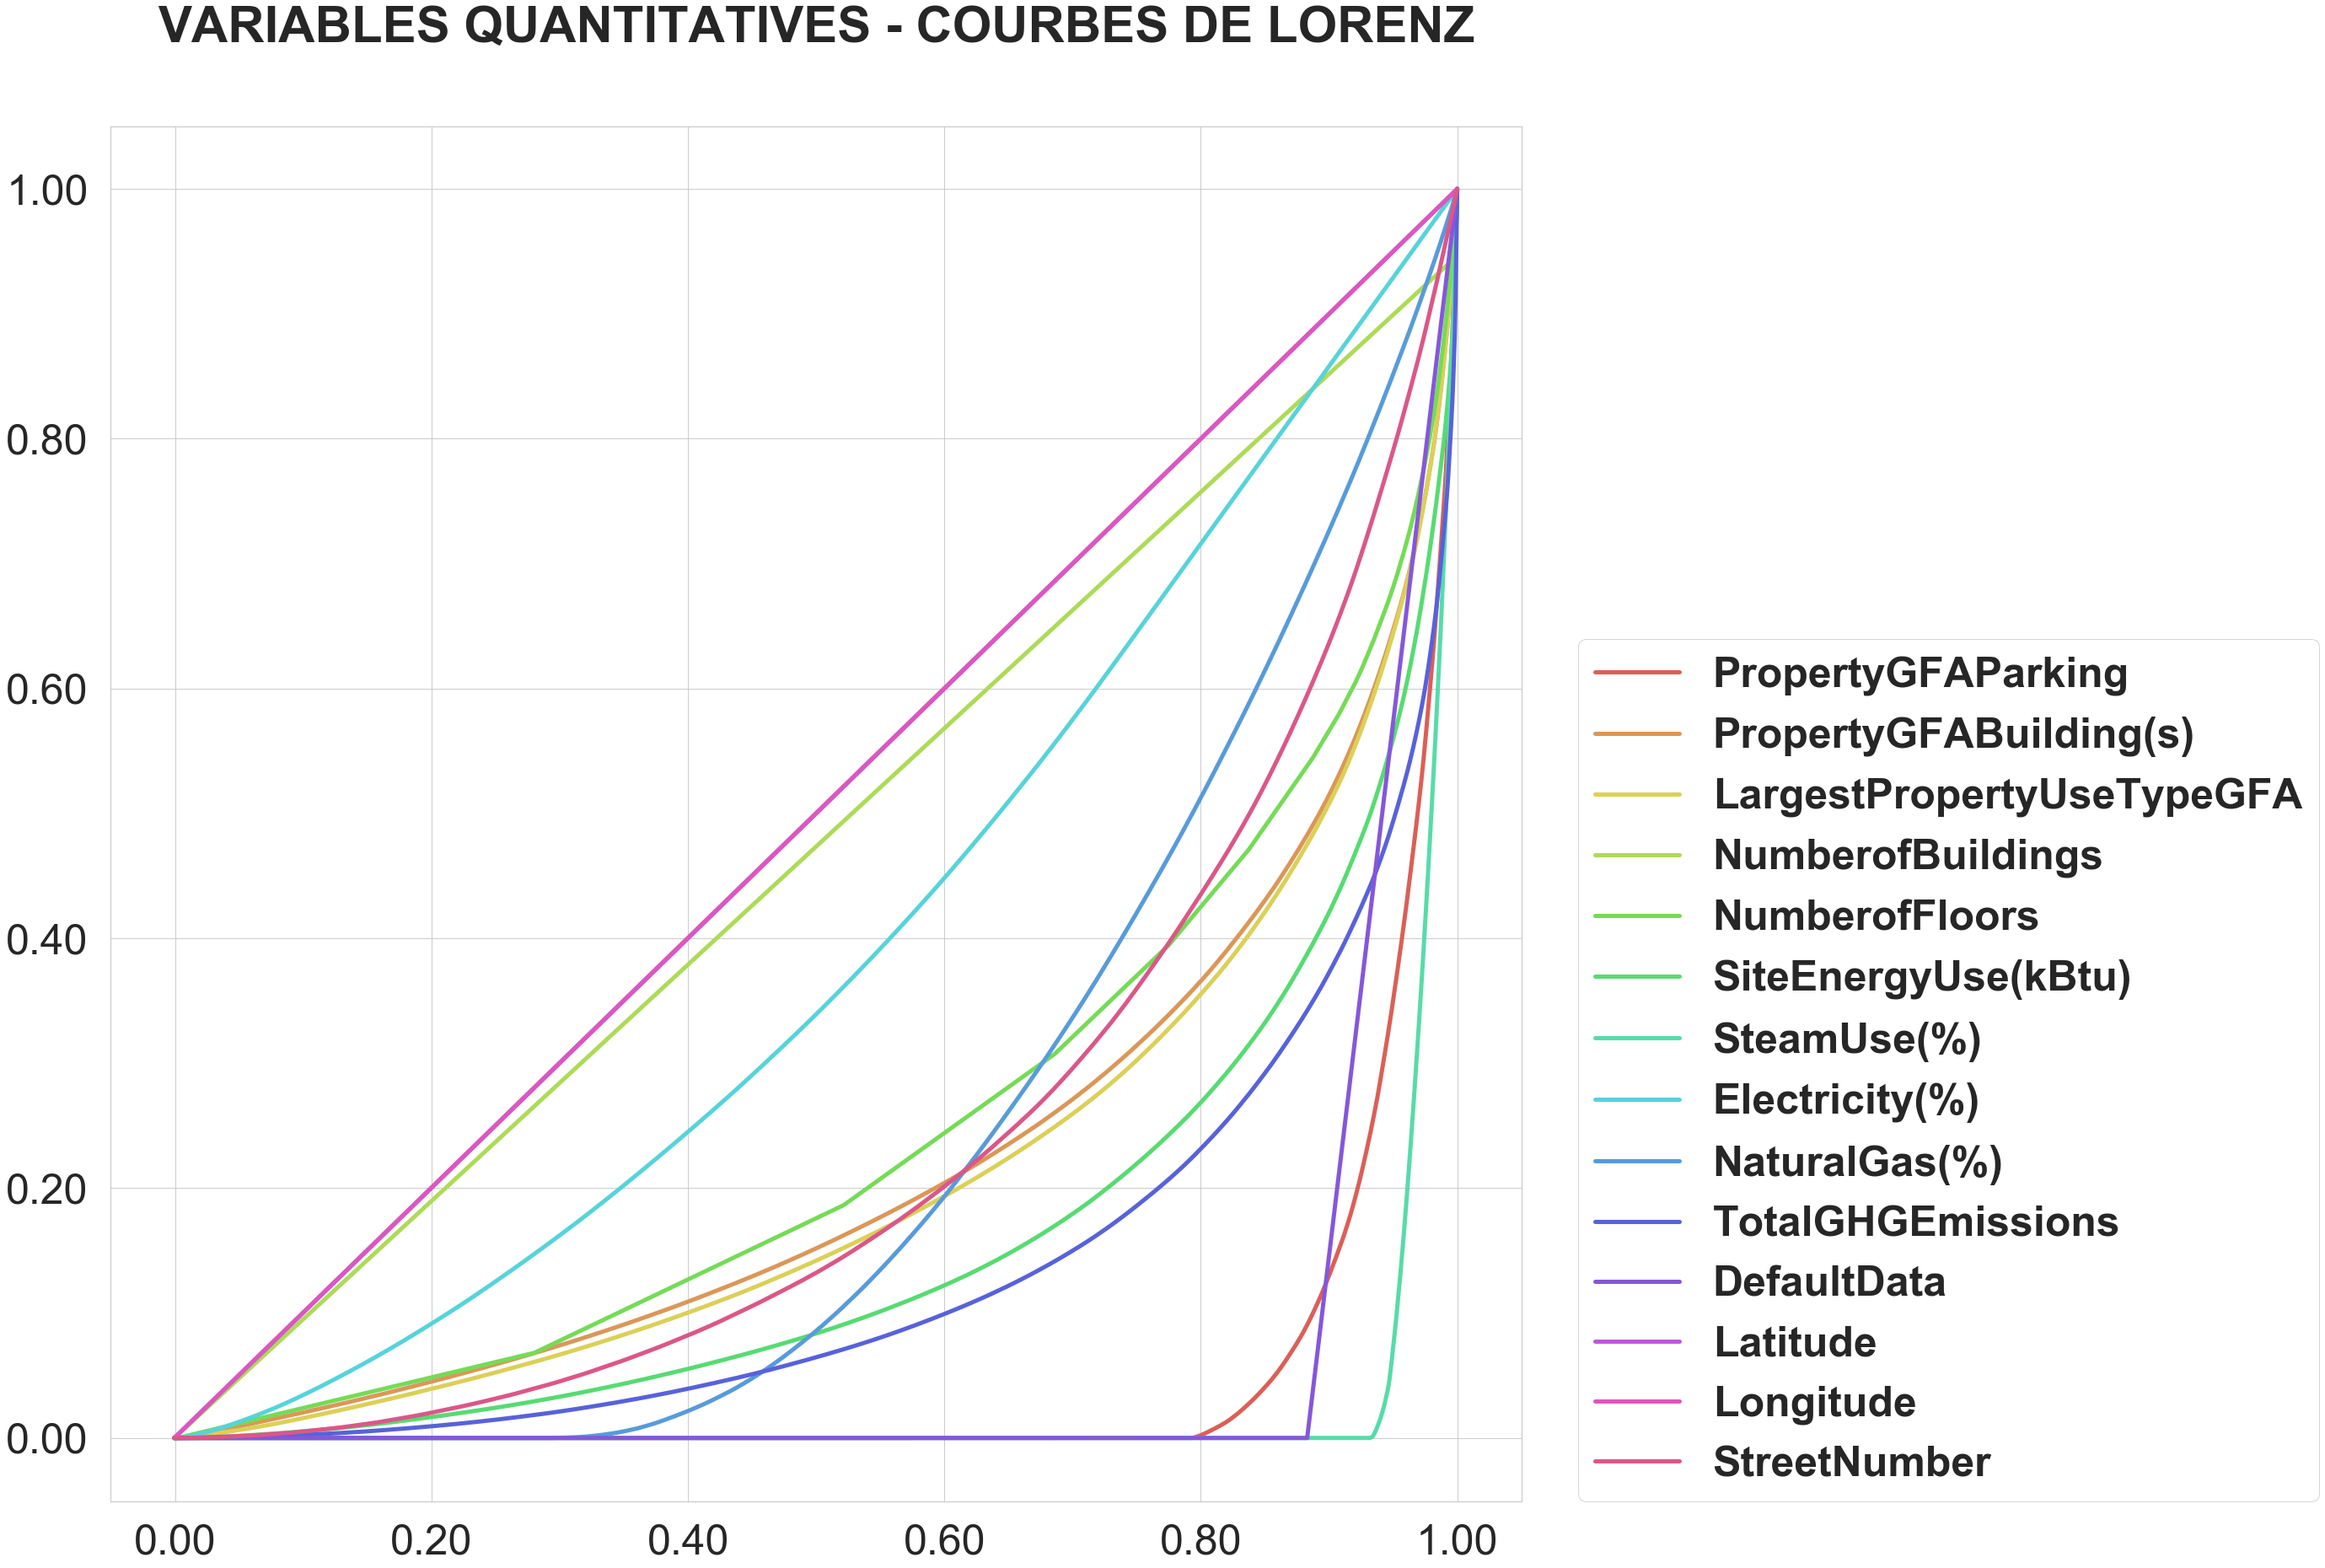

In [53]:
hf.plotLorenz(lorenzs, 30, 30)

Les courbes de Lorenz mettent bien en évidence le caractère globalement inégalitaire des distributions des variables, excepté pour la latitude et la longitude, confondues avec la 1ère bissectrice.
Le nombre de bâtiments et la proportion de consommation en électricité sont également relativement proches de la 1ère bissectrice.

Ceci est attendu puisque les données concernent la seule ville de Seattle, d'où de faibles variations de latitude et de longitude. 
Il est également attendu que le nombre de bâtiments varie peu (en moyenne 1 bâtiment par construction comme indiqué par les grandeurs statistiques précédentes), de même que la proportion d'utilisation d'électricité, qui est la source majoritaire sur l'ensemble des bâtiments parmi les 3 sources d'énergie considérées.

____
#### 4.3 ÉTUDE DE LA 1ère VARIABLE D'INTÉRÊT : LA CONSOMMATION ÉNERGÉTIQUE TOTALE (SiteEnergyUse)

#### _<u>4.3.1 Étude des corrélations des variables qualitatives avec la consommation énergétique totale</u>_

In [54]:
eta_df = pd.DataFrame()

for qual_col in qualitative_cols:
    eta_df[qual_col] = [hf.eta_squared(train_test_data, qual_col,"SiteEnergyUse(kBtu)")]

eta_df.T.rename(columns={0:"Coeff de corrélation"}).sort_values("Coeff de corrélation", ascending=False)

Coeff de corrélation
LargestPropertyUseType              0.412491
PrimaryPropertyType                 0.341899
YearBuilt                           0.092357
ZipCode                             0.049440
Neighborhood                        0.036381
BuildingType                        0.030547

Les features qualitatifs qui ressortent particulièrement sont :
- **LargestPropertyUseType**
- **PrimaryPropertyType**

_<u>Consommation énergétique en fonction du type d'utilisation principal du bâtiment (LargestPropertyUseType)<u>_

In [55]:
mean_conso_per_ppt = pd.DataFrame()

for ppt, data_ppt in train_test_data.groupby(["LargestPropertyUseType"]):
    mean_conso_per_ppt[ppt] = [np.log(data_ppt['SiteEnergyUse(kBtu)'].mean())]

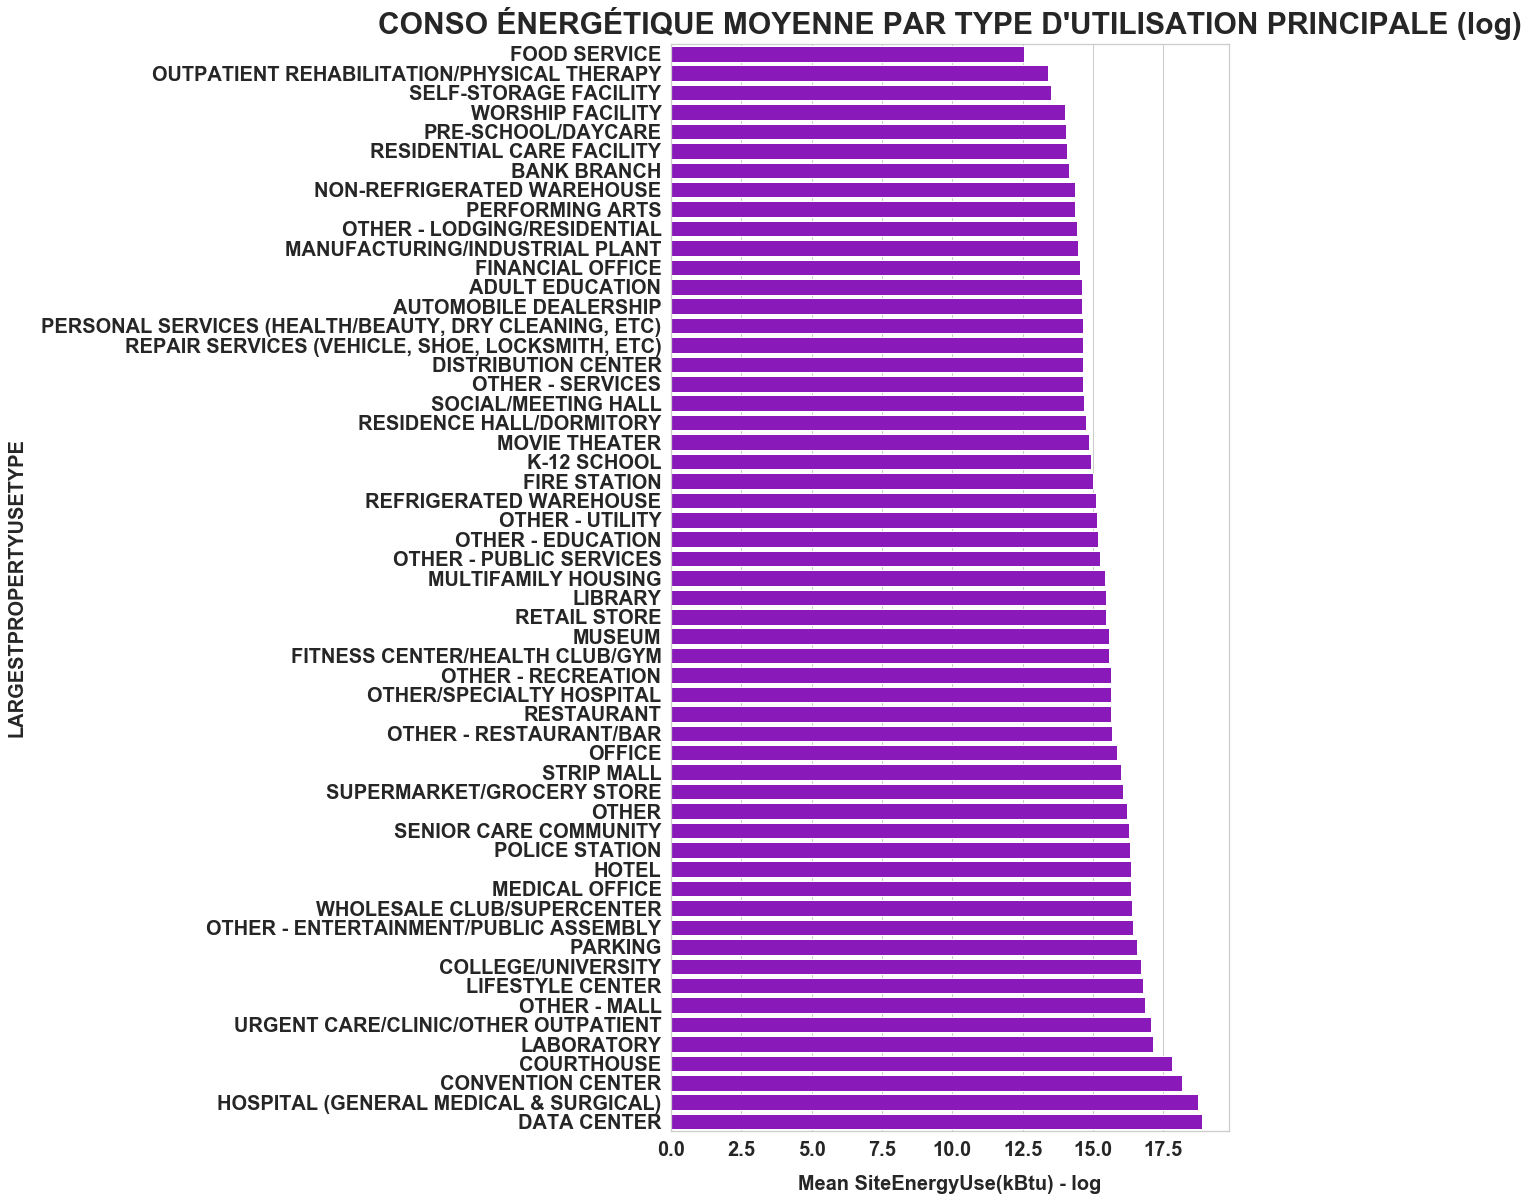

In [56]:
data_to_plot = mean_conso_per_ppt.T.rename(columns={0:"Mean SiteEnergyUse(kBtu) - log"})\
               .sort_values("Mean SiteEnergyUse(kBtu) - log")\
               .reset_index().rename(columns={"index":"LargestPropertyUseType"})

hf.plotBarplot(data_to_plot, "Mean SiteEnergyUse(kBtu) - log", "LargestPropertyUseType", 20, 10, 
            "CONSO ÉNERGÉTIQUE MOYENNE PAR TYPE D'UTILISATION PRINCIPALE (log)")

#### _<u>4.3.2 Étude des corrélations des variables quantitatives avec la consommation énergétique totale</u>_

Nous allons ici observer le coefficient de corrélation de Spearman et sa p-value associée. 

- Le coefficient de Spearman indique l'existence de relations monotones entre 2 variables.
- L'hypothèse nulle étant définie comme proposant que les variables sont indépendantes, la p-value est la probabilité pour qu'un modèle statistique donné sous l'hypothèse nulle obtienne la même valeur ou une valeur encore plus extrême que celle proposée. En termes de valeur p, l'hypothèse nulle est généralement rejetée lorsque p ≤ 0,05.



Nous n'inclurons pas les émissions carbone annuelles dans notre analyse car celles-ci ne pourront pas être utilisées pour la modélisation : elles représenteraient une fuite de données.

/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


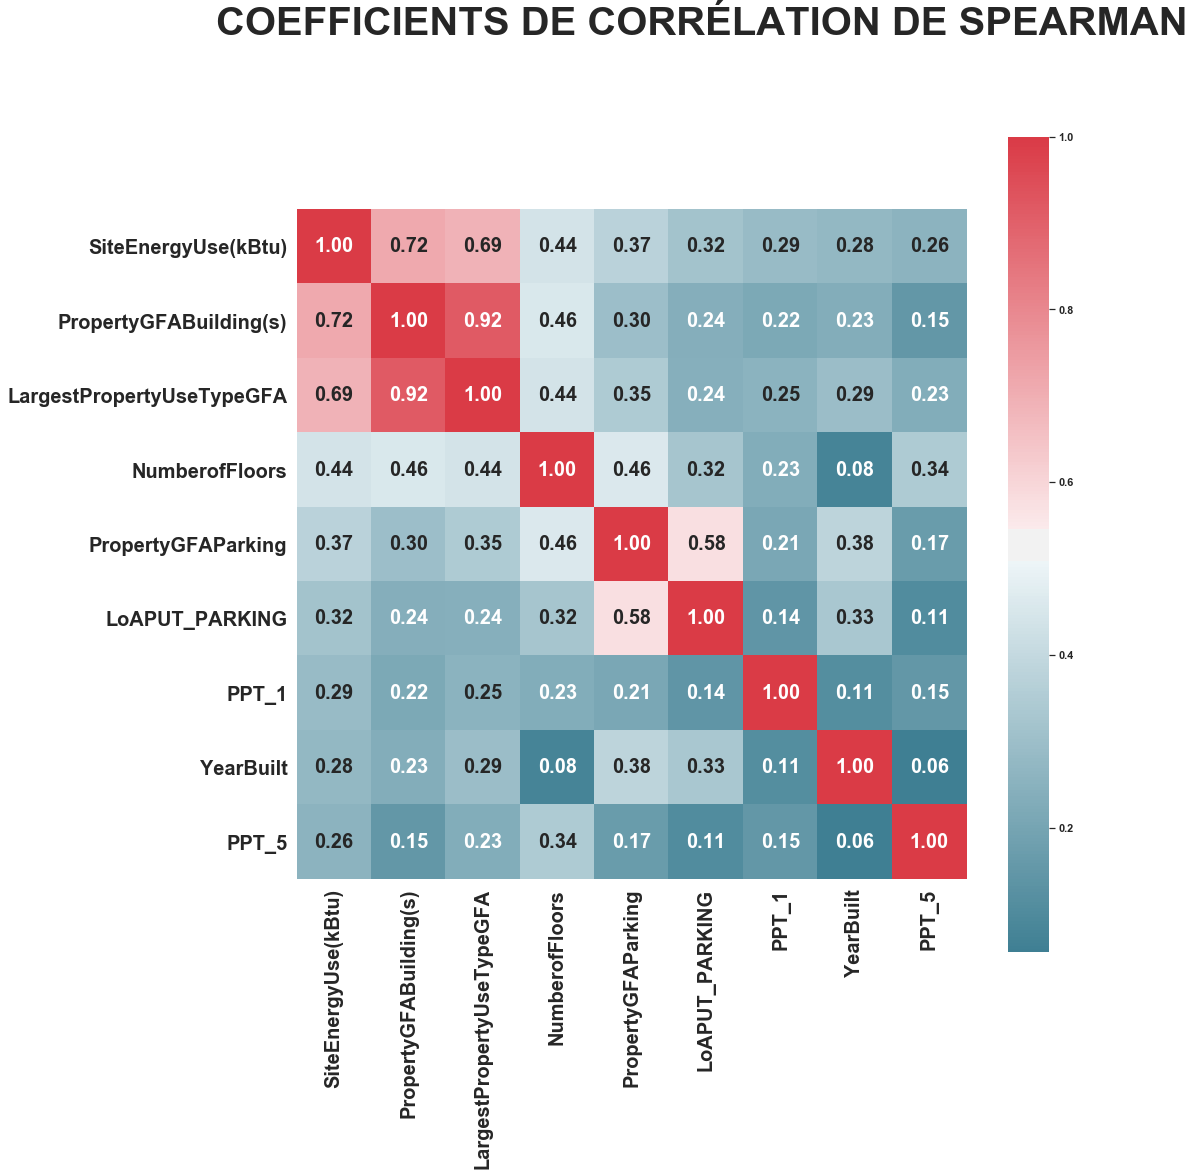

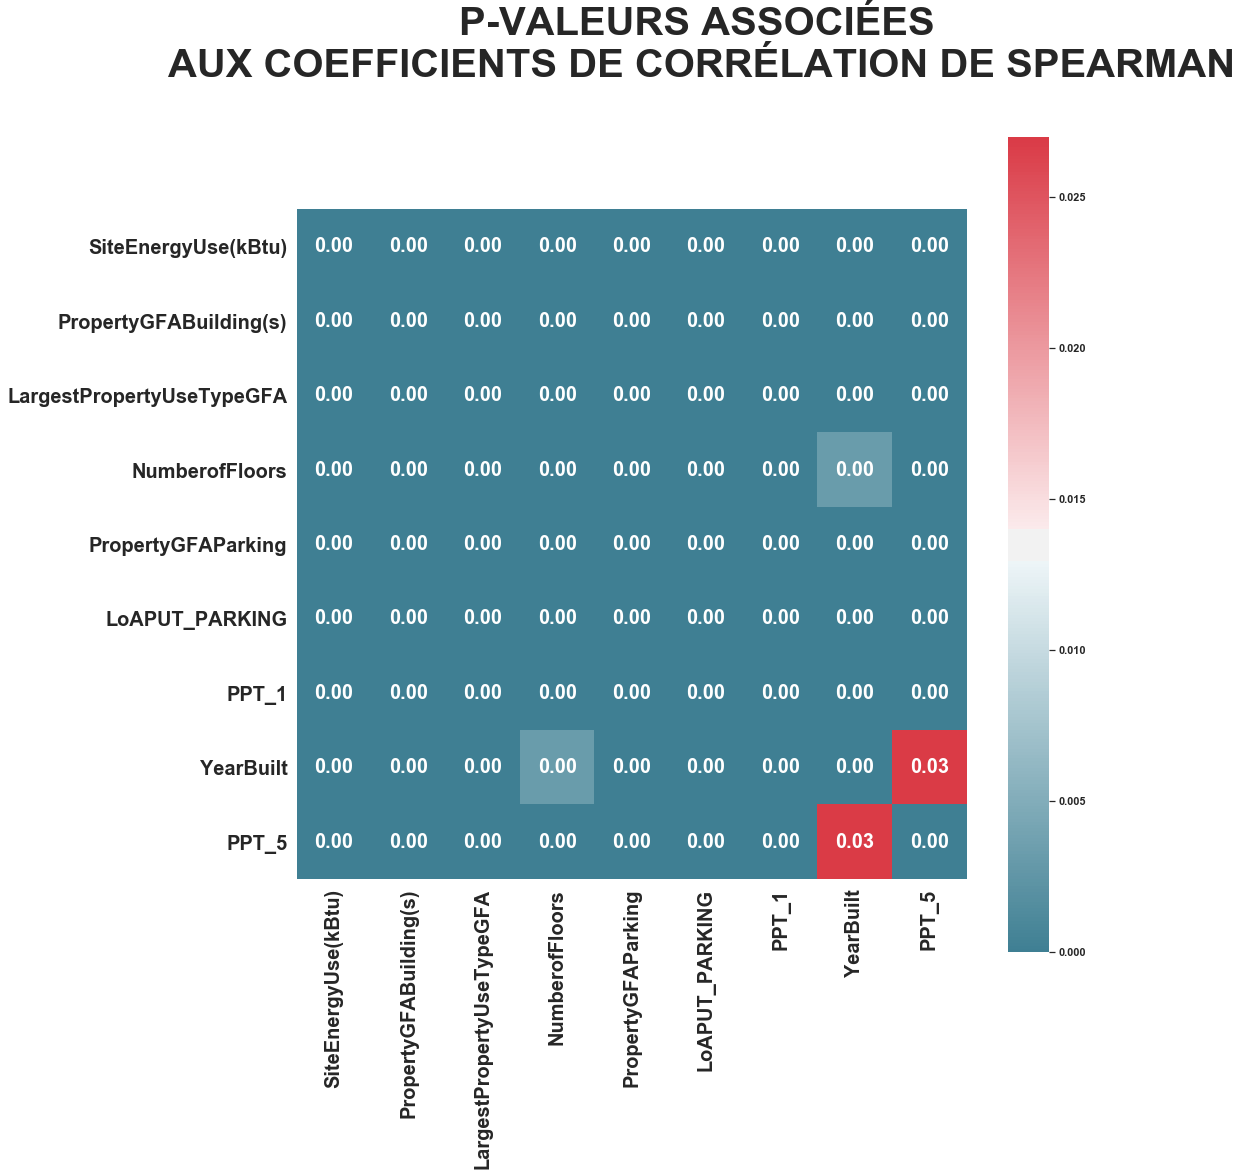

In [57]:
FEATURE = "SiteEnergyUse(kBtu)"

interest_cols = quantitative_cols + ["ZipCode", "YearBuilt"] \
                                  + LPUT_cols + PPT_cols + BT_cols \
                                  + LoAPUT_cols + NB_cols + SN_cols
interest_cols.remove(FEATURE)

# On retire les émissions carbone annuelles
interest_cols.remove("TotalGHGEmissions")

THRESHOLD = 0.25

corrs_heatmap_df, ps_heatmap_df = hf.getRhoPValueHeatmaps(train_test_data, interest_cols, FEATURE, THRESHOLD)

hf.plotCorrelationHeatMap(corrs_heatmap_df, 15, 15, "COEFFICIENTS DE CORRÉLATION DE SPEARMAN")
hf.plotCorrelationHeatMap(ps_heatmap_df, 15, 15, "P-VALEURS ASSOCIÉES \nAUX COEFFICIENTS DE CORRÉLATION DE SPEARMAN")

Toutes les corrélations obtenues avec la consommation énergétique ont une p-value très proche de 0 (précision de plus de 2 décimales). L'hypothèse nulle proposant que les variables seraient indépendantes peut donc être rejetée avec près de 100% de certitude.

On peut ainsi obtenir les variables les plus corrélées avec la consommation énergétique (coeff de corr. > 25%) :  
- **0.72 avec PropertyGFABuilding(s)**
- **0.69 avec LargestPropertyUseTypeGFA**
- 0.44 avec NumberofFloors
- 0.37 avec PropertyGFAParking
- 0.32 avec LoAPUT_PARKING
- 0.29 avec PPT_1
- 0.28 avec YearBuilt
- 0.26 avec PPT_5

_<u>Consommation énergétique totale en fonction des features les plus corrélés (hors sources d'énergie)</u>_

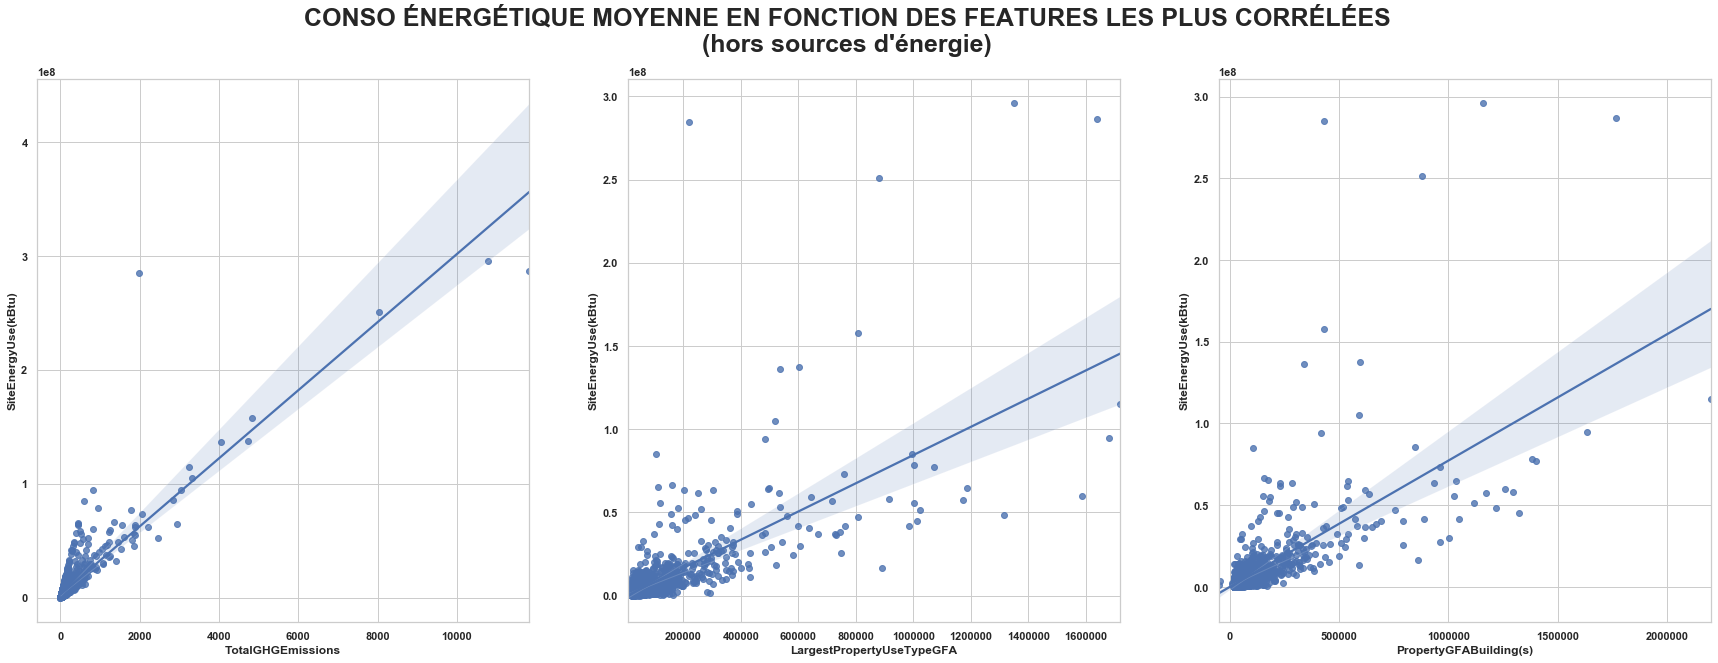

In [58]:
hf.plot3Regplots(train_test_data, "TotalGHGEmissions", "LargestPropertyUseTypeGFA", "PropertyGFABuilding(s)",
                 "SiteEnergyUse(kBtu)", 10, 30, 
                 "CONSO ÉNERGÉTIQUE MOYENNE EN FONCTION DES FEATURES LES PLUS CORRÉLÉES\n(hors sources d'énergie)",
                )

____
#### 4.4 ÉTUDE DE LA 2nde VARIABLE D'INTÉRÊT : LES ÉMISSIONS DE CO2 (TotalGHGEmissions)

#### _<u>4.4.1 Étude des corrélations des variables qualitatives avec les émissions de CO2</u>_

In [59]:
eta_df = pd.DataFrame()

for qual_col in qualitative_cols:
    eta_df[qual_col] = [hf.eta_squared(train_test_data, qual_col,"TotalGHGEmissions")]

eta_df.T.rename(columns={0:"Coeff de corrélation"}).sort_values("Coeff de corrélation", ascending=False)

Coeff de corrélation
LargestPropertyUseType              0.438241
PrimaryPropertyType                 0.417730
YearBuilt                           0.076009
Neighborhood                        0.027472
ZipCode                             0.026485
BuildingType                        0.024105

Les features qualitatifs qui ressortent particulièrement sont :
- **LargestPropertyUseType**
- **PrimaryPropertyType**

_<u>Consommation énergétique en fonction du type d'utilisation principal du bâtiment (LargestPropertyUseType)<u>_

In [60]:
mean_conso_per_ppt = pd.DataFrame()

for ppt, data_ppt in train_test_data.groupby(["LargestPropertyUseType"]):
    mean_conso_per_ppt[ppt] = [np.log(data_ppt['TotalGHGEmissions'].mean())]

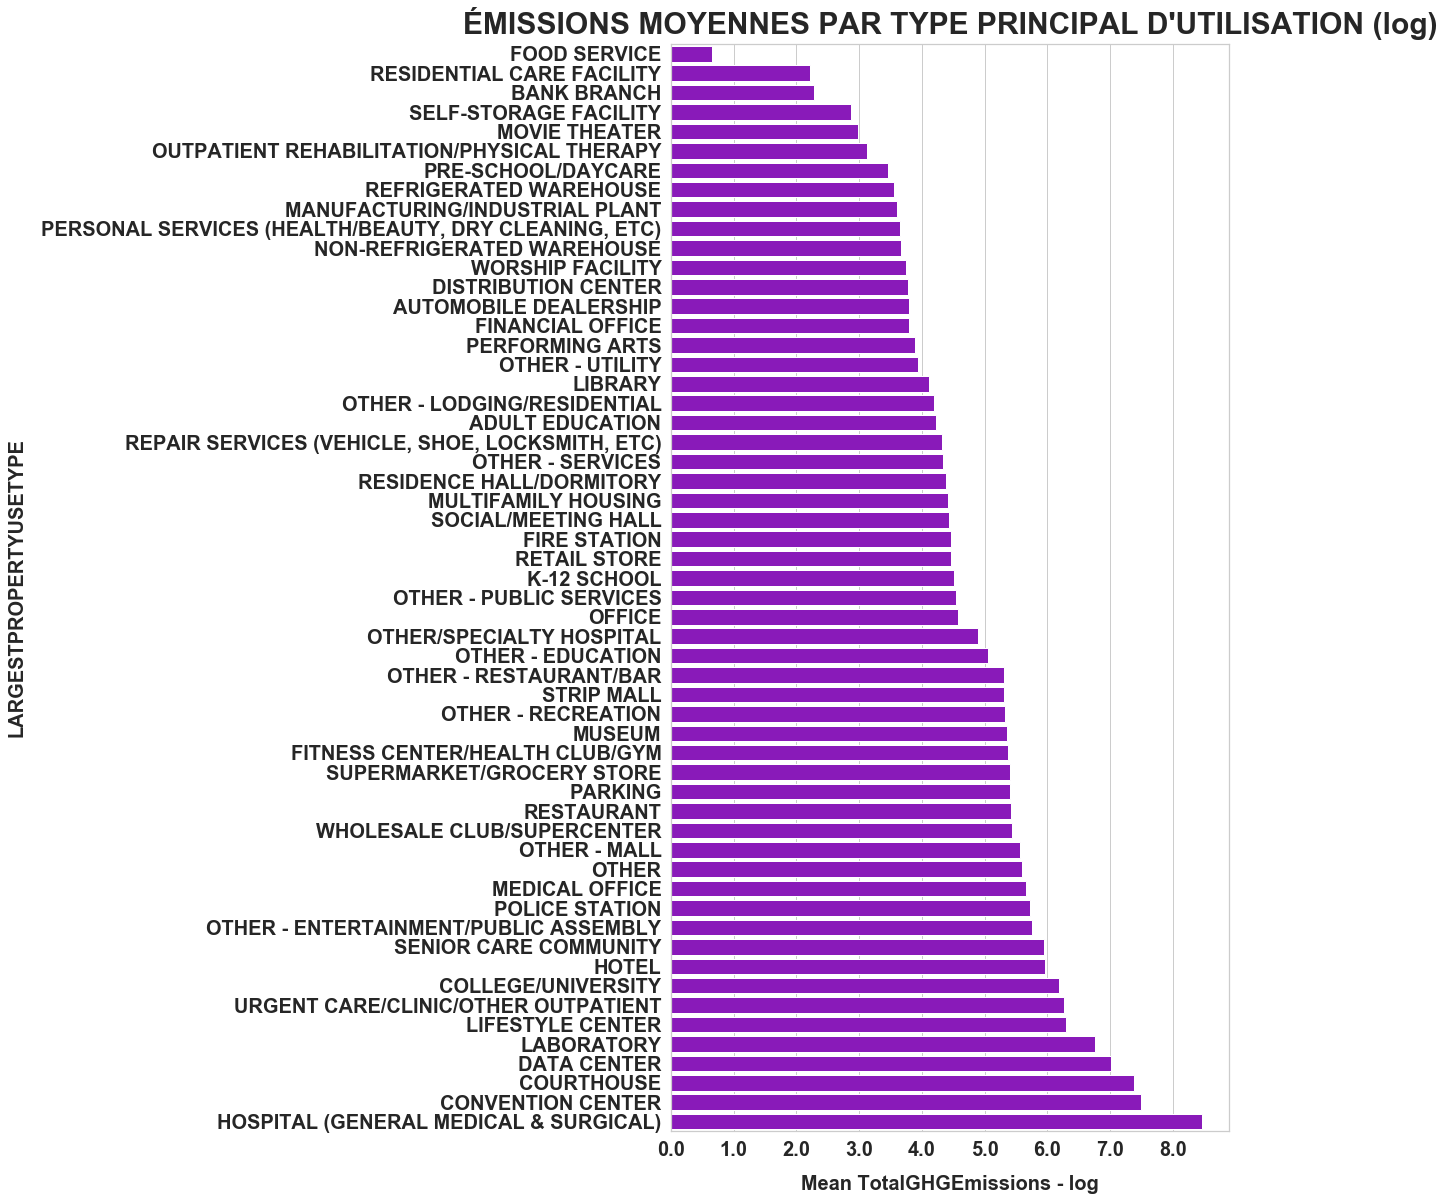

In [61]:
data_to_plot = mean_conso_per_ppt.T.rename(columns={0:"Mean TotalGHGEmissions - log"})\
               .sort_values("Mean TotalGHGEmissions - log")\
               .reset_index().rename(columns={"index":"LargestPropertyUseType"})

hf.plotBarplot(data_to_plot, "Mean TotalGHGEmissions - log", "LargestPropertyUseType", 20, 10, 
            "ÉMISSIONS MOYENNES PAR TYPE PRINCIPAL D'UTILISATION (log)")

#### _<u>4.4.2 Étude des corrélations des variables quantitatives avec les émissions de CO2</u>_

Nous allons ici observer le coefficient de corrélation de Spearman et sa p-value associée. 

- Le coefficient de Spearman indique l'existence de relations monotones entre 2 variables.
- L'hypothèse nulle étant définie comme proposant que les variables sont indépendantes, la p-value est la probabilité pour qu'un modèle statistique donné sous l'hypothèse nulle obtienne la même valeur ou une valeur encore plus extrême que celle proposée. En termes de valeur p, l'hypothèse nulle est généralement rejetée lorsque p ≤ 0,05.



Nous n'inclurons pas la consommation énergétique annuelle dans notre analyse car celles-ci ne pourront pas être utilisées pour la modélisation : elles représenteraient une fuite de données.

/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


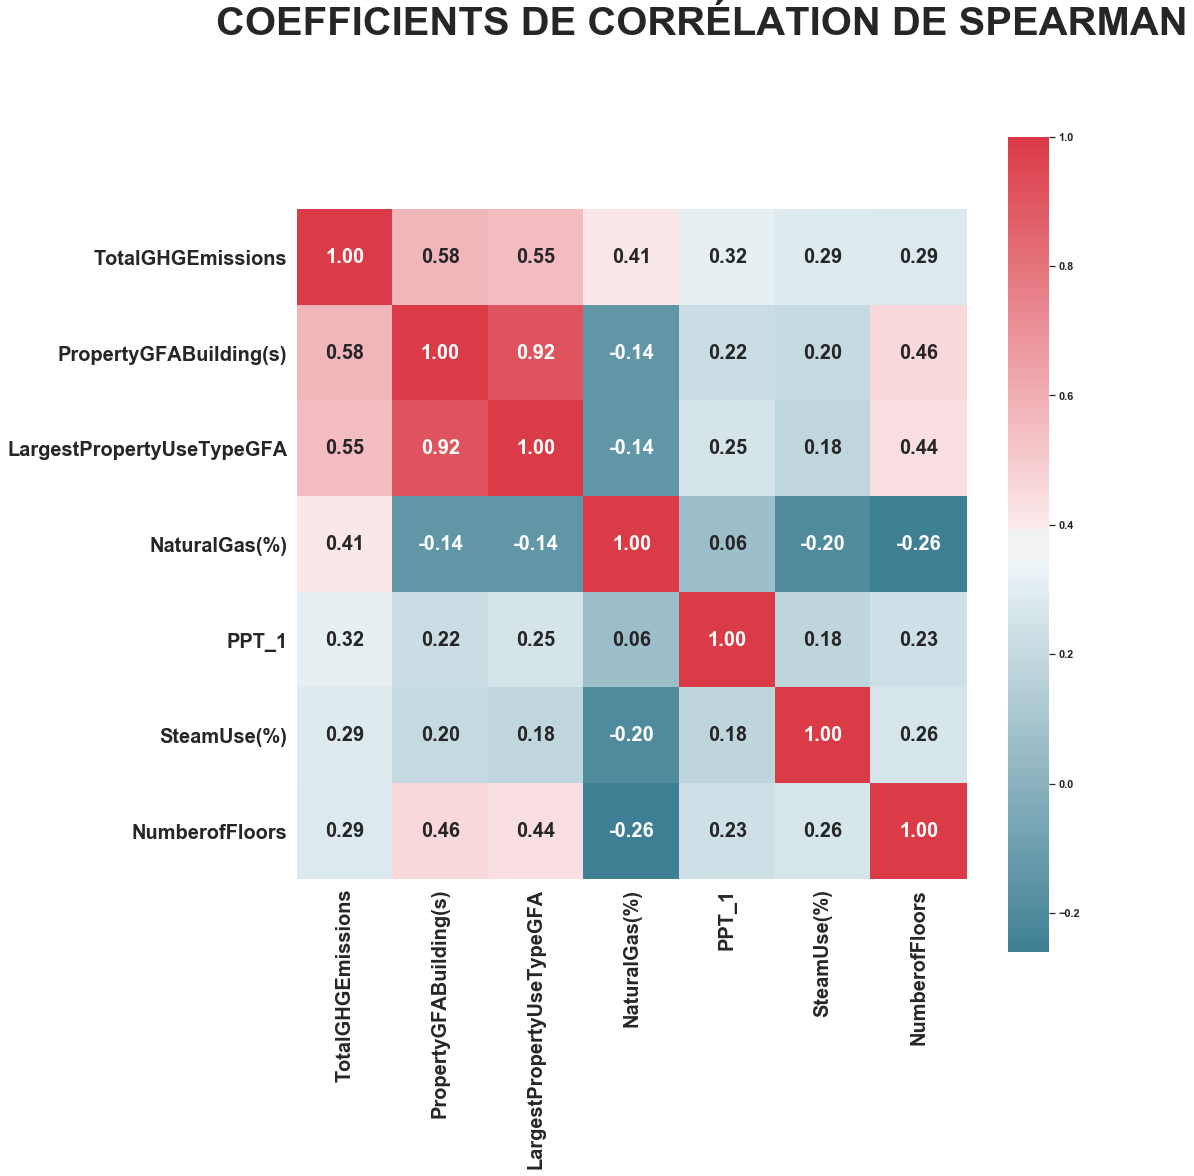

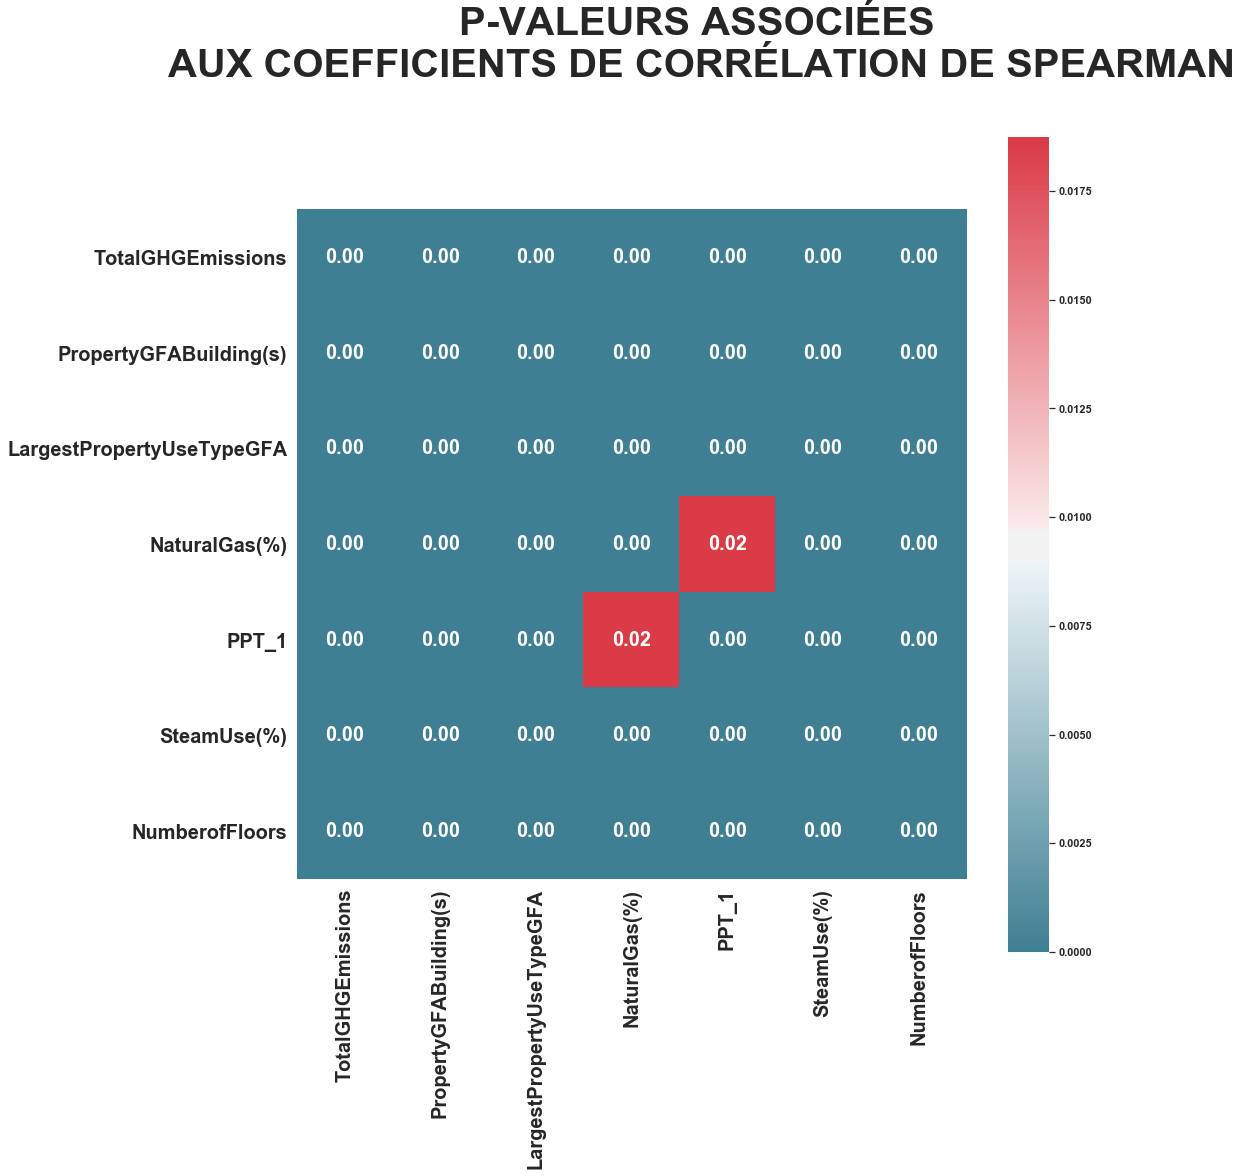

In [62]:
FEATURE = "TotalGHGEmissions"

interest_cols = quantitative_cols + ["ZipCode", "YearBuilt"] + LPUT_cols + PPT_cols\
                             + BT_cols + LoAPUT_cols + NB_cols + SN_cols
interest_cols.remove(FEATURE)

# On retire la consommation énergétique annuelle
interest_cols.remove("SiteEnergyUse(kBtu)")

THRESHOLD = 0.25

corrs_heatmap_df, ps_heatmap_df = hf.getRhoPValueHeatmaps(train_test_data, interest_cols, FEATURE, THRESHOLD)

hf.plotCorrelationHeatMap(corrs_heatmap_df, 15, 15, "COEFFICIENTS DE CORRÉLATION DE SPEARMAN")
hf.plotCorrelationHeatMap(ps_heatmap_df, 15, 15, "P-VALEURS ASSOCIÉES \nAUX COEFFICIENTS DE CORRÉLATION DE SPEARMAN")

Toutes les corrélations obtenues avec les émissions de CO2 ont une p-value très proche de 0 (précision de plus de 2 décimales). L'hypothèse nulle proposant que les variables seraient indépendantes peut donc être rejetée avec près de 100% de certitude.

On peut ainsi obtenir les variables les plus corrélées avec les émissions de CO2 (coeff. de corr. > 25%) : 

- **0.58 avec PropertyGFABuilding(s)**
- **0.55 avec LargestPropertyUseTypeGFA**
- 0.41 avec NaturalGas(%)
- 0.32 avec PPT_1
- 0.29 avec SteamUse(%)
- 0.29 avec NumberofFloors

_<u>Emissions de CO2 en fonction des features les plus corrélés (hors sources d'énergie)</u>_

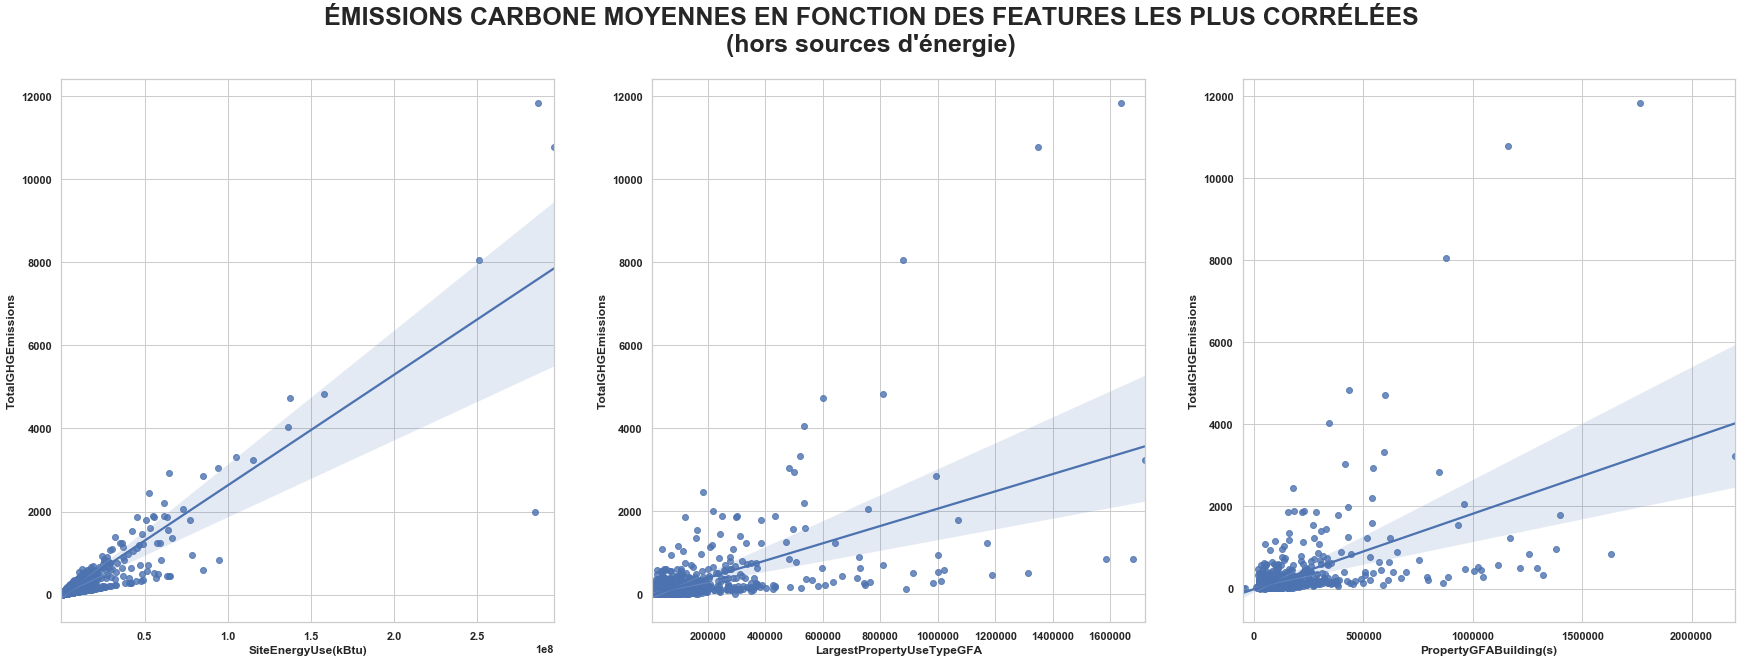

In [63]:
hf.plot3Regplots(train_test_data, "SiteEnergyUse(kBtu)", "LargestPropertyUseTypeGFA", "PropertyGFABuilding(s)",
                 "TotalGHGEmissions", 10, 30,
                 "ÉMISSIONS CARBONE MOYENNES EN FONCTION DES FEATURES LES PLUS CORRÉLÉES\n(hors sources d'énergie)"
                )

___
### 5. EXPORT DES DONNÉES

In [64]:
train_test_data.to_csv("./sources/energy_data_2015-cleaned.csv")

In [65]:
validation_data.to_csv("./sources/energy_data_2016-cleaned.csv")

___
### 6. CONCLUSION

Le jeu de données est bien renseigné, avec peu de données manquantes. Toutefois, les features possèdent des distributions relativement inégales, ce qui pourrait avoir des conséquences sur la qualité globale d'un modèle de prédiction basé sur ces données.

Après nettoyage des données, cette courte analyse exploratoire met en lumière les features les plus corrélées aux deux variables d'intéret.

**CONSOMMATION ÉNERGÉTIQUE TOTALE <i>SiteEnergyUse(kBtu)</i>**
    * la consommation en électricité (<i>Electricity(kBtu)</i>)
    * les émissions de dioxyde de carbone (<i>TotalGHGEmissions</i>)
    * la surface du bâtiment (<i>PropertyGFABuilding(s)</i>)
    * la surface consacrée à l'activité principale du bâtiment (<i>LargestPropertyUseTypeGFA</i>)
    
**ÉMISSIONS DE CO2 <i>TotalGHGEmissions</i>**
    * la consommation energetique totale (<i>SiteEnergyUse(kBtu)</i>)
    * la consommation en gaz naturel (<i>NaturalGas(kBtu)</i>)
    * la consommation en electricite (<i>Electricity(kBtu)</i>)
    * la surface du ou des bâtiments (<i>PropertyGFABuilding(s)</i>)
    * la surface consacrée à l'activité principale du ou des bâtiments (<i>LargestPropertyUseTypeGFA</i>)

___
### 7. ANNEXE

In [66]:
############### PROJET 4 #################

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import time
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from scipy import stats

##########################################
#                                        #
# Fonctions de calcul et de descriptions #
#                                        #
##########################################

def getMissingValuesPercentPer(data):
    '''
        Calculates the mean percentage of missing values
        in a given pandas dataframe per unique value
        of a given column
        
        Parameters
        ----------------
        data                : pandas dataframe
                              The dataframe to be analyzed
        
        Returns
        ---------------
        missing_percent_df  : A pandas dataframe containing:
                                - a column "column"
                                - a column "Percent Missing" containing the percentage of
                                  missing value for each value of column
    '''
    
    missing_percent_df = pd.DataFrame({'Percent Missing':data.isnull().sum()/len(data)*100})

    missing_percent_df['Percent Filled'] = 100 - missing_percent_df['Percent Missing']

    missing_percent_df['Total'] = 100

    percent_missing = data.isnull().sum() * 100 / len(data.columns)
    
    return missing_percent_df


#------------------------------------------

def descriptionJeuDeDonnees(sourceFiles):
    '''
        Outputs a presentation pandas dataframe for the dataset.
        
        Parameters
        ----------------
        sourceFiles     : dict with :
                            - keys : the names of the files
                            - values : a list containing two values :
                                - the dataframe for the data
                                - a brief description of the file
        
        Returns
        ---------------
        presentation_df : pandas dataframe :
                            - a column "Nom du fichier" : the name of the file
                            - a column "Nb de lignes"   : the number of rows per file
                            - a column "Nb de colonnes" : the number of columns per file
                            - a column "Description"    : a brief description of the file
    '''

    print("Les données se décomposent en {} fichier(s): \n".format(len(sourceFiles)))

    filenames = []
    files_nb_lines = []
    files_nb_columns = []
    files_descriptions = []

    for filename, file_data in sourceFiles.items():
        filenames.append(filename)
        files_nb_lines.append(len(file_data[0]))
        files_nb_columns.append(len(file_data[0].columns))
        files_descriptions.append(file_data[1])

        
    # Create a dataframe for presentation purposes
    presentation_df = pd.DataFrame({'Nom du fichier':filenames,
                                    'Nb de lignes':files_nb_lines,
                                    'Nb de colonnes':files_nb_columns,
                                    'Description': files_descriptions})

    presentation_df.index += 1

    
    return presentation_df

#------------------------------------------

def eta_squared(data, x_qualit,y_quantit):
    '''
        Calculate the proportion of variance
        in the given quantitative variable for
        the given qualitative variable
        
        ----------------
        - data      : dataframe
                      Working data
        - x_quantit : The name of the qualitative variable
        - y_quantit : The name of the quantitative variable
        
        Returns
        ---------------
        Eta_squared : float
    '''
    
    sous_echantillon = data.copy().dropna(how="any")

    x = sous_echantillon[x_qualit]
    y = sous_echantillon[y_quantit]

    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
#------------------------------------------

def getLorenzGini(data):
    '''
        Calculate the lorenz curve and Gini coeff
        for a given variable
        
        ----------------
        - data       : data series
                       Working  data
        
        Returns
        ---------------
        A tuple containing :
        - lorenz_df  : list
                       The values for the Lorenz curve
        - gini_coeff : float
                       The associated Gini coeff
        
        Source : www.openclassrooms.com
    '''
    
    dep = data.dropna().values
    n = len(dep)
    lorenz = np.cumsum(np.sort(dep)) / dep.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

    #---------------------------------------------------
    # Gini :
    # Surface sous la courbe de Lorenz. Le 1er segment
    # (lorenz[0]) est à moitié en dessous de 0, on le
    # coupe donc en 2, on fait de même pour le dernier
    # segment lorenz[-1] qui est à 1/2 au dessus de 1.
    #---------------------------------------------------

    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
    # surface entre la première bissectrice et le courbe de Lorenz
    S = 0.5 - AUC
    gini_coeff = [2*S]
         
    return (lorenz, gini_coeff)
    
#------------------------------------------

def getLorenzsGinis(data):
    '''
        Calculate the lorenz curve and Gini coeffs
        for all columns in the given dataframe
        
        ----------------
        - data       : dataframe
                       Working data
        
        Returns
        ---------------
        A tuple containing :
        - lorenz_df  : dataframne
                       The values for the Lorenz curve for each
                       column of the given dataframe
        - gini_coeff : dataframe
                       The associated Gini coeff for each column of
                       the given dataframe
    '''
    
    ginis_df = pd.DataFrame()
    lorenzs_df = pd.DataFrame()

    for ind_quant in data.columns.unique().tolist():
        lorenz, gini = getLorenzGini(data[ind_quant])
        ginis_df[ind_quant] = gini
        lorenzs_df[ind_quant] = lorenz

    n = len(lorenzs_df)
    xaxis = np.linspace(0-1/n,1+1/n,n+1)
    lorenzs_df["index"]=xaxis[:-1]
    lorenzs_df.set_index("index", inplace=True)
    
    ginis_df = ginis_df.T.rename(columns={0:'Indice Gini'})
    
    return (lorenzs_df, ginis_df)
 
#------------------------------------------
def getRhoPValueHeatmaps(data, interest_cols, FEATURE, THRESHOLD):
    '''
        Calculates the rho of Spearman for a given dataset
        and a given set of features compared to FEATURE.
        It returns the dataframe corresponding to a heatmap of the rho
        containing only the features whose rho is superior to THRESHOLD.
        
        Parameters
        ----------------
        data            : pandas dataframe
                          Data containing interest_cols and FEATURE as features.
                          All features must be numeric.
                                 
        interest_cols   : list
                          The names of the features to calculate the rho
                          of Spearman compared to FEATURE
        
        FEATURE         : string
                          The name of the feature to calculate the rho of Spearman
                          against.
        
        THRESHOLD       : float
                          The function will return only those features whose rho is
                          superior to THRESHOLD
        
        Returns
        ---------------
        sorted_corrs_df : pandas dataframe
                          The rhos of Spearnma, sorted by feature of highest rho
        sorted_ps_df    : pandas dataframe
                          The p-values associated to the calculated rhos
    '''
    
    # Calcul du rho de Spearman avec p-value
    corrs, ps = stats.spearmanr(data[FEATURE],
                                data[interest_cols])

    # Transformation des arrays en DataFrame
    corrs_df = pd.DataFrame(corrs)
    ps_df = pd.DataFrame(ps)

    # Renommage des colonnes
    interest_cols.insert(0, FEATURE)
    corrs_df.columns=interest_cols
    ps_df.columns=interest_cols

    # Suppression des colonnes dont le rho est < THRESHOLD
    x = corrs_df[corrs_df[FEATURE]>THRESHOLD].index

    corrs_df = corrs_df.iloc[x,x].reset_index(drop=True).sort_values([FEATURE], ascending=False)
    ps_df = ps_df.iloc[x,x].reset_index(drop=True)

    # Classement des colonnes par ordre de rho décroissant
    sort_rows_ps_df = pd.DataFrame()

    for x in corrs_df.index.tolist():
        sort_rows_ps_df = pd.concat([sort_rows_ps_df, pd.DataFrame(ps_df.iloc[x, :]).T])

    # Tri par ordre de plus grand rho
    sorted_corrs_df = pd.DataFrame()
    sorted_ps_df = pd.DataFrame()

    for x in corrs_df.sort_values([FEATURE], ascending=False).index.tolist():
        sorted_corrs_df = pd.concat([sorted_corrs_df, corrs_df.iloc[:,x]], axis=1)
        sorted_ps_df = pd.concat([sorted_ps_df, sort_rows_ps_df.iloc[:,x]], axis=1)

    sorted_corrs_df["Index"] = sorted_corrs_df.columns
    sorted_corrs_df.set_index("Index", inplace=True)
    sorted_ps_df["Index"] = sorted_ps_df.columns
    sorted_ps_df.set_index("Index", inplace=True)

    sorted_corrs_df.index.name = None
    sorted_ps_df.index.name = None

    return (sorted_corrs_df, sorted_ps_df)
 
##########################################
#                                        #
# Fonctions de graphiques                #
#                                        #
##########################################

def plotPercentageMissingValuesFor(data, long, larg):
    '''
        Plots the proportions of filled / missing values for each unique value
        in column as a horizontal bar chart.
        
        Parameters
        ----------------
        data : pandas dataframe with:
                - a column column
                - a column "Percent Filled"
                - a column "Percent Missing"
                - a column "Total"
                                 
       long : int
            The length of the figure for the plot
        
        larg : int
               The width of the figure for the plot
                                  
        
        Returns
        ---------------
        -
    '''
    
    data_to_plot = getMissingValuesPercentPer(data).sort_values("Percent Filled").reset_index()

    TITLE_SIZE = 60
    TITLE_PAD = 100
    TICK_SIZE = 50
    TICK_PAD = 20
    LABEL_SIZE = 50
    LABEL_PAD = 50
    LEGEND_SIZE = 50


    sns.set(style="whitegrid")

    sns.set_palette(sns.dark_palette("purple", reverse=True))

    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(long, larg))

    plt.title("PROPORTIONS DE VALEURS RENSEIGNÉES / NON-RENSEIGNÉES PAR COLONNE",
              fontweight="bold",
              fontsize=TITLE_SIZE, pad=TITLE_PAD)

    # Plot the Total values
    b = sns.barplot(x="Total", y="index", data=data_to_plot,label="non renseignées", color="thistle", alpha=0.3)
    b.set_xticklabels(b.get_xticks(), size = TICK_SIZE)
    _, ylabels = plt.yticks()
    _, xlabels = plt.xticks()
    b.set_yticklabels(ylabels, size=TICK_SIZE)


    # Plot the Percent Filled values
    c = sns.barplot(x="Percent Filled", y="index", data=data_to_plot,label="renseignées", color="darkviolet")
    c.set_xticklabels(c.get_xticks(), size = TICK_SIZE)
    c.set_yticklabels(ylabels, size=TICK_SIZE)


    # Add a legend and informative axis label
    ax.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0, ncol=1, frameon=True,
             fontsize=LEGEND_SIZE)

    ax.set(ylabel="Colonnes",xlabel="Pourcentage de valeurs (%)")

    lx = ax.get_xlabel()
    ax.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

    ly = ax.get_ylabel()
    ax.set_ylabel(ly, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:2d}'.format(int(x)) + '%'))
    ax.tick_params(axis='both', which='major', pad=TICK_PAD)

    sns.despine(left=True, bottom=True)

    plt.savefig('missingPercentagePerColumn.png')

    # Display the figure
    plt.show()

#------------------------------------------

def plotPieChart(data, long, larg, title):
    '''
        Plots a pie chart of the proportion of each modality for groupby_col
        with the dimension (long, larg), with the given title and saved figure
        title.
        
        Parameters
        ----------------
        data           : pandas dataframe
                         Working data, with a "groupby_col" column
        
        groupby_col    : string
                         The name of the quantitative column of which the modality
                         frequency should be plotted.
                                  
        long           : int
                         The length of the figure for the plot
        
        larg           : int
                         The width of the figure for the plot
        
        title          : string
                         title for the plot
        
        title_fig_save : string
                         title under which to save the figure
                 
        Returns
        ---------------
        -
    '''
    
    TITLE_SIZE = 25
    TITLE_PAD = 60

    # Initialize the figure
    f, ax = plt.subplots(figsize=(long, larg))


    # Set figure title
    # Set figure title
    plt.title(title,
              fontweight="bold",
              fontsize=TITLE_SIZE, pad=TITLE_PAD)
       
    # Put everything in bold
    #plt.rcParams["font.weight"] = "bold"

    # Create pie chart for topics
    a = data.plot(kind='pie', autopct=lambda x:'{:2d}'.format(int(x)) + '%', fontsize =20)
    # Remove y axis label
    ax.set_ylabel('')
    
    # Make pie chart round, not elliptic
    plt.axis('equal')
    
    # Display the figure
    plt.show()

#------------------------------------------

def plotQualitativeDist(data, long, larg):
    '''
        Displays a bar chart showing the frequency of the modalities
        for each column of data.
        
        Parameters
        ----------------
        data : dataframe
               Working data containing exclusively qualitative data
                                 
        long : int
               The length of the figure for the plot
        
        larg : int
               The width of the figure for the plot
        
        Returns
        ---------------
        -
    '''

    TITLE_SIZE = 80
    TITLE_PAD = 1.05
    TICK_SIZE = 40
    TICK_PAD = 20
    LABEL_SIZE = 50
    LABEL_PAD = 30
    LEGEND_SIZE = 30
    LINE_WIDTH = 3.5

    nb_rows = 3
    nb_cols = 2

    f, axes = plt.subplots(nb_rows, nb_cols, figsize=(long, larg))

    f.suptitle("DISTRIBUTION DES VALEURS QUALITATIVES", fontweight="bold",
              fontsize=TITLE_SIZE, y=TITLE_PAD)


    row = 0
    column = 0

    for ind_qual in data.columns.tolist():
        
        data_to_plot = data.sort_values(by=ind_qual).copy()
        
        ax = axes[row, column]
        
        b = sns.countplot(y=ind_qual,
                          data=data_to_plot,
                          color="darkviolet",
                          ax=ax,
                          order = data_to_plot[ind_qual].value_counts().index)


        plt.tight_layout()
        
        plt.subplots_adjust(left=None,
                            bottom=None,
                            right=None,
                            top=None,
                            wspace=1.4, hspace=0.2)

        b.set_xticklabels(b.get_xticks(), size = TICK_SIZE)
        
        if ind_qual == "nova_group":
            ylabels = [item.get_text()[0] for item in ax.get_yticklabels()]
        else:
            ylabels = [item.get_text().upper() for item in ax.get_yticklabels()]
        b.set_yticklabels(ylabels, size=TICK_SIZE, weight="bold")

        lx = ax.get_xlabel()
        ax.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
        
        ly = ax.get_ylabel()
        ax.set_ylabel(ly.upper(), fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:d}'.format(int(x))))
        
        ax.xaxis.grid(True)

        if column < nb_cols-1:
            column += 1
        else:
            row += 1
            column = 0
        
#------------------------------------------

def plotBoxPlots(data, long, larg, nb_rows, nb_cols):
    '''
        Displays a boxplot for each column of data.
        
        Parameters
        ----------------
        data    : dataframe
                  Working data containing exclusively quantitative data
                                 
        long    : int
                  The length of the figure for the plot
        
        larg    : int
                  The width of the figure for the plot
               
        nb_rows : int
                  The number of rows in the subplot
        
        nb_cols : int
                  The number of cols in the subplot
                                  
        Returns
        ---------------
        -
    '''

    TITLE_SIZE = 35
    TITLE_PAD = 1.05
    TICK_SIZE = 15
    TICK_PAD = 20
    LABEL_SIZE = 25
    LABEL_PAD = 10
    LEGEND_SIZE = 30
    LINE_WIDTH = 3.5

    f, axes = plt.subplots(nb_rows, nb_cols, figsize=(long, larg))

    f.suptitle("VALEURS QUANTITATIVES - DISTRIBUTION", fontweight="bold",
              fontsize=TITLE_SIZE, y=TITLE_PAD)


    row = 0
    column = 0

    for ind_quant in data.columns.tolist():
        ax = axes[row, column]

        sns.despine(left=True)

        b = sns.boxplot(x=data[ind_quant], ax=ax, color="darkviolet")

        plt.setp(axes, yticks=[])

        plt.tight_layout()

        b.set_xticklabels(b.get_xticks(), size = TICK_SIZE)

        lx = ax.get_xlabel()
        ax.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
        
        if ind_quant == "salt_100g":
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(float(x))))
        else:
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:d}'.format(int(x))))

        ly = ax.get_ylabel()
        ax.set_ylabel(ly, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

        ax.tick_params(axis='both', which='major', pad=TICK_PAD)

        ax.xaxis.grid(True)
        ax.set(ylabel="")

        if column < nb_cols-1:
            column += 1
        else:
            row += 1
            column = 0
                    
#------------------------------------------

def plotLorenz(lorenz_df, long, larg):
    '''
        Plots a Lorenz curve with the given title
        
        Parameters
        ----------------
        - lorenz_df : dataframe
                      Working data containing the Lorenz values
                      one column = lorenz value for a variable
                      
        - long      : int
                      The length of the figure for the plot
        
        - larg      : int
                      The width of the figure for the plot
        
        Returns
        ---------------
        _
    '''
    
    TITLE_SIZE = 60
    TITLE_PAD = 100
    TICK_SIZE = 50
    TICK_PAD = 20
    LABEL_SIZE = 50
    LABEL_PAD = 50
    LEGEND_SIZE = 50


    sns.set(style="whitegrid")
    
    f, ax = plt.subplots(figsize=(long, larg))
    
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    
    plt.title("VARIABLES QUANTITATIVES - COURBES DE LORENZ",
              fontweight="bold",
              fontsize=TITLE_SIZE, pad=TITLE_PAD)

    # Plot the Total values
    sns.set_color_codes("pastel")
    
    b = sns.lineplot(data=lorenz_df, palette=sns.color_palette("hls", len(lorenz_df.columns)),
                    linewidth=5, dashes=False)
    
    b.set_xticklabels(b.get_xticks(), size = TICK_SIZE)

    b.set_yticklabels(b.get_yticks(), size = TICK_SIZE)

    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(float(x))))

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(float(x))))
    
    ax.tick_params(axis='both', which='major', pad=TICK_PAD)

    ax.set_xlabel("")

    # Add a legend and informative axis label
    leg = ax.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0, ncol=1, frameon=True,
             fontsize=LEGEND_SIZE)
    
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)


    # Display the figure
    plt.show()

#------------------------------------------

def plotCorrelationHeatMap(data,long, larg, title):
    '''
        Plots a heatmap of the correlation coefficients
        between the quantitative columns in data
        
        Parameters
        ----------------
        - data : dataframe
                 Working data
                 
        - corr : string
                 the correlation method ("pearson" or "spearman")
        
        - long : int
                 The length of the figure for the plot
        
        - larg : int
                 The width of the figure for the plot
        
        Returns
        ---------------
        _
    '''

    TITLE_SIZE = 40
    TITLE_PAD = 1
    TICK_SIZE = 20
    TICK_PAD = 20
    LABEL_SIZE = 45
    LABEL_PAD = 30
    LEGEND_SIZE = 30
    LINE_WIDTH = 3.5

    f, ax = plt.subplots(figsize=(long, larg))
                
    f.suptitle(title, fontweight="bold",
               fontsize=TITLE_SIZE, y=TITLE_PAD)

    b = sns.heatmap(data, mask=np.zeros_like(data, dtype=np.bool),
                    cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax,
                    annot=data, annot_kws={"fontsize":20}, fmt=".2f")

    xlabels = [item.get_text() for item in ax.get_xticklabels()]
    b.set_xticklabels(xlabels, size=TICK_SIZE, weight="bold")
    b.set_xlabel(data.columns.name,fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

    ylabels = [item.get_text() for item in ax.get_yticklabels()]
    b.set_yticklabels(ylabels, size=TICK_SIZE, weight="bold")
    b.set_ylabel(data.index.name,fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

    plt.show()

#------------------------------------------

def plotEnergySourcesDistributionFor(data, criterion, long, larg):
    '''
        Plots the proportions of use per energy source in % for each value
        taken by criterion as a stacked horizontal bar chart
        
        Parameters
        ----------------
        data   : pandas dataframe with:
                    - an index named criterion containing the different criterion
                      values
                    - a column per energy source containing the cumulated % of
                      energy source use (the current energy source + the value for the
                      previous column) for that energy source for each criterion value
                 
                                 
        long   : int
                 The length of the figure for the plot
        
        larg   : int
                 The width of the figure for the plot
                                
        Returns
        ---------------
        -
    '''

    TITLE_SIZE = 60
    TITLE_PAD = 100
    TICK_SIZE = 50
    TICK_PAD = 30
    LABEL_SIZE = 50
    LABEL_PAD = 50
    LEGEND_SIZE = 30

    # Reset index to access the Seuil as a column
    data_to_plot = data.reset_index()

    sns.set(style="whitegrid")
    palette = sns.husl_palette(len(data.columns))

    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(long, larg))

    plt.title("RÉPARTITION DES SOURCES D'ÉNERGIE",
              fontweight="bold",fontsize=TITLE_SIZE, pad=TITLE_PAD)

    # Get the list of topics from the columns of data
    column_list = list(data.columns)

    # Create a barplot with a distinct color for each topic
    for idx, column in enumerate(reversed(column_list)):
        color = palette[idx]
        b = sns.barplot(x=column, y=criterion, data=data_to_plot, label=str(column), orient="h", color=color)
        
        b.set_xticklabels(b.get_xticks(), size = TICK_SIZE)
        _, ylabels = plt.yticks()
        b.set_yticklabels(ylabels, size=TICK_SIZE)

        
    # Add a legend and informative axis label

    ax.legend(bbox_to_anchor=(0,-0.6,1,0.2), loc="lower left", mode="expand",
              borderaxespad=0, ncol=1, frameon=True, fontsize=LEGEND_SIZE)

    ax.set(ylabel="Type du bâtiment principal",xlabel="% des sources d'énergie")

    lx = ax.get_xlabel()
    ax.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

    ly = ax.get_ylabel()
    ax.set_ylabel(ly, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:2d}'.format(int(x))))

    ax.tick_params(axis='both', which='major', pad=TICK_PAD)

    sns.despine(left=True, bottom=True)

    # Display the figure
    plt.show()

#------------------------------------------

def plotBarplot(data, col_x, col_y, long, larg, title):
    '''
        Plots a horizontal bar plot
        
        Parameters
        ----------------
        data    : pandas dataframe
                  Working data containing col_x et col_y
        
        col_x   : string
                  Name of the features to use for x
                  
        col_y   : string
                  Name of the features to use for y
                 
        long    : int
                  The length of the figure for the plot
        
        larg    : int
                  The width of the figure for the plot
                                  
        title   : string
                  Title for the plot
                  
        Returns
        ---------------
        -
    '''
    
    LABEL_SIZE = 20
    LABEL_PAD = 15

    f, ax = plt.subplots(figsize=(larg, long))

    plt.title(title,
                  fontweight="bold",
                  fontsize=30, pad=10)

    b = sns.barplot(x=col_x, y=col_y,
                    data=data,
                    label="non renseignées",
                    color="darkviolet")

    b.set_xticklabels(b.get_xticks(), size = 20)
    _, ylabels = plt.yticks()
    _, xlabels = plt.xticks()
    _=b.set_yticklabels(ylabels, size=20)

    lx = ax.get_xlabel()
    ax.set_xlabel(lx, fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")
            
    ly = ax.get_ylabel()
    ax.set_ylabel(ly.upper(), fontsize=LABEL_SIZE, labelpad=LABEL_PAD, fontweight="bold")

#------------------------------------------

def plot3Regplots(data, col_x1, col_x2, col_x3, col_y, long, larg, title):
    '''
        Plots 3 regplots horizontally in a single figure
        
        Parameters
        ----------------
        data   : pandas dataframe
                 Working data
                 
        col_x1 : string
                 Name of the feature to use for x in the 1st regplot
         
        col_x2 : string
                 Name of the feature to use for x in the 2nd regplot
                 
        col_x3 : string
                Name of the feature to use for x in the 3rd regplot
        
        col_y : string
                Name of the feature to use for y in the regplots
        
        long   : int
                 The length of the figure for the plot
        
        larg   : int
                 The width of the figure for the plot
                
        title   : string
                  The title for the plot
        
        Returns
        ---------------
        -
    '''
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(larg, long))

    plt.suptitle(title, fontweight="bold", fontsize=25)

    sns.regplot(x=data[col_x1], y=data[col_y], ax=ax1)
    sns.regplot(x=data[col_x2], y=data[col_y], ax=ax2)
    sns.regplot(x=data[col_x3], y=data[col_y], ax=ax3)